# Load the libraries

In [1]:
library(data.table);
library(ggplot2);
library(repr)
library(reshape2)
library(pheatmap)
library(cowplot)
library(RColorBrewer)
library(sva)
library(ggExtra)
library(grid)
library(gridExtra)
library(caret)
library(kernlab)
source("figure2_helper_functions.R")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: lattice

Attaching package: ‘kernlab’

The following object is masked from ‘package:ggplot2’:

    alpha



In [2]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=80)
name <- "CLUESImmVar_processed"
version <- "v6.1";
fig_dir <- paste("figures.",version,sep="")

# Load the differentially expression results

In [3]:
pbmc_deseq <- fread(paste("deseq.",version,"/",version,"..PBMC.deseq.txt",sep=""))
th_deseq <- as.data.frame(fread(paste("deseq.",version,"/",version,"..Th.deseq.txt",sep="")))
tc_deseq <- as.data.frame(fread(paste("deseq.",version,"/",version,"..Tc.deseq.txt",sep="")))
cm_deseq <- as.data.frame(fread(paste("deseq.",version,"/",version,"..cM.deseq.txt",sep="")))
ncm_deseq <- as.data.frame(fread(paste("deseq.",version,"/",version,"..ncM.deseq.txt",sep="")))
b_deseq <- as.data.frame(fread(paste("deseq.",version,"/",version,"..B.deseq.txt",sep="")))
nk_deseq <- as.data.frame(fread(paste("deseq.",version,"/",version,"..NK.deseq.txt",sep="")))
cdc_deseq <- as.data.frame(fread(paste("deseq.",version,"/",version,"..cDC.deseq.txt",sep="")))
pdc_deseq <- as.data.frame(fread(paste("deseq.",version,"/",version,"..pDC.deseq.txt",sep="")))

Warning message in fread(paste("deseq.", version, "/", version, "..PBMC.deseq.txt", :
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread(paste("deseq.", version, "/", version, "..Th.deseq.txt", :
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread(paste("deseq.", version, "/", version, "..Tc.deseq.txt", :
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which 

In [4]:
pbmc_deseq_sig_genes <- pbmc_deseq$V1[intersect(which(pbmc_deseq$baseMean > 25), intersect(which(abs(pbmc_deseq$log2FoldChange)>1),which(pbmc_deseq$qval < 0.01)))]
cm_deseq_sig_genes <- cm_deseq$V1[intersect(which(cm_deseq$baseMean > 25), intersect(which(abs(cm_deseq$log2FoldChange)>1),which(cm_deseq$qval < 0.01)))]
th_deseq_sig_genes <- th_deseq$V1[intersect(which(th_deseq$baseMean > 25), intersect(which(abs(th_deseq$log2FoldChange)>1),which(th_deseq$qval < 0.01)))]
tc_deseq_sig_genes <- tc_deseq$V1[intersect(which(tc_deseq$baseMean > 25), intersect(which(abs(tc_deseq$log2FoldChange)>1),which(tc_deseq$qval < 0.01)))]
b_deseq_sig_genes <- b_deseq$V1[intersect(which(b_deseq$baseMean > 25), intersect(which(abs(b_deseq$log2FoldChange)>1),which(b_deseq$qval < 0.01)))]
ncm_deseq_sig_genes <- ncm_deseq$V1[intersect(which(ncm_deseq$baseMean > 25), intersect(which(abs(ncm_deseq$log2FoldChange)>1),which(ncm_deseq$qval < 0.01)))]
nk_deseq_sig_genes <- nk_deseq$V1[intersect(which(nk_deseq$baseMean > 25), intersect(which(abs(nk_deseq$log2FoldChange)>1),which(nk_deseq$qval < 0.01)))]
cdc_deseq_sig_genes <- cdc_deseq$V1[intersect(which(cdc_deseq$baseMean > 25), intersect(which(abs(cdc_deseq$log2FoldChange)>1),which(cdc_deseq$qval < 0.01)))]
pdc_deseq_sig_genes <- pdc_deseq$V1[intersect(which(pdc_deseq$baseMean > 25), intersect(which(abs(pdc_deseq$log2FoldChange)>1),which(pdc_deseq$qval < 0.01)))]

union_deseq_sig_genes <- unique(c(pbmc_deseq_sig_genes, cm_deseq_sig_genes, ncm_deseq_sig_genes, cdc_deseq_sig_genes, pdc_deseq_sig_genes, th_deseq_sig_genes, tc_deseq_sig_genes,  nk_deseq_sig_genes,b_deseq_sig_genes))
cat("Number of union of significant genes: ", length(union_deseq_sig_genes),"\n")
cat("Number of significant PBMC genes: ", length(pbmc_deseq_sig_genes))

deseq_sig_genes <- union_deseq_sig_genes

Number of union of significant genes:  198 
Number of significant PBMC genes:  141

# Load the necessary expression input

## Load the processed expression data

In [5]:
pdc_expr <- fread(paste("expr.",version,"/",version,".full.pDC.blind.expr.txt",sep=""))
colnames(pdc_expr) <- sapply(colnames(pdc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
expr_gene_names <- pdc_expr$V1;
pdc_expr <- as.matrix(pdc_expr[,-1]);

th_expr <- as.matrix(fread(paste("expr.",version,"/",version,".full.Th.blind.expr.txt",sep=""))[,-1]);
colnames(th_expr) <- sapply(colnames(th_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
th_expr <- th_expr[,colnames(pdc_expr)];

tc_expr <- as.matrix(fread(paste("expr.",version,"/",version,".full.Tc.blind.expr.txt",sep=""))[,-1]);
colnames(tc_expr) <- sapply(colnames(tc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
tc_expr <- tc_expr[,colnames(pdc_expr)];

ncm_expr <- as.matrix(fread(paste("expr.",version,"/",version,".full.ncM.blind.expr.txt",sep=""))[,-1]);
colnames(ncm_expr) <- sapply(colnames(ncm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
ncm_expr <- ncm_expr[,colnames(pdc_expr)];

b_expr <- as.matrix(fread(paste("expr.",version,"/",version,".full.B.blind.expr.txt",sep=""))[,-1]);
colnames(b_expr) <- sapply(colnames(b_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
b_expr <- b_expr[,colnames(pdc_expr)];

nk_expr <- as.matrix(fread(paste("expr.",version,"/",version,".full.NK.blind.expr.txt",sep=""))[,-1]);
colnames(nk_expr) <- sapply(colnames(nk_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
nk_expr <- nk_expr[,colnames(pdc_expr)];

cdc_expr <- as.matrix(fread(paste("expr.",version,"/",version,".full.cDC.blind.expr.txt",sep=""))[,-1]);
colnames(cdc_expr) <- sapply(colnames(cdc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cdc_expr <- cdc_expr[,colnames(pdc_expr)];

cm_expr <- as.matrix(fread(paste("expr.",version,"/",version,".full.cM.blind.expr.txt",sep=""))[,-1]);
colnames(cm_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cm_expr <- cm_expr[,colnames(pdc_expr)];

pbmc_expr <- as.matrix(fread(paste("expr.",version,"/",version,".full.PBMC.blind.expr.txt",sep=""))[,-1]);
colnames(pbmc_expr) <- sapply(colnames(pbmc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
pbmc_expr <- pbmc_expr[,colnames(pdc_expr)];

rownames(pbmc_expr) <- rownames(cm_expr) <- rownames(th_expr) <- rownames(tc_expr) <- rownames(ncm_expr) <- rownames(b_expr) <- rownames(nk_expr) <-rownames(cdc_expr) <-rownames(pdc_expr) <- expr_gene_names;

## do a quick filter for all zeros
any_zeros = unique(c(which(rowSums(pbmc_expr) ==0),
                     which(rowSums(cm_expr)==0),
                     which(rowSums(ncm_expr)==0),
                     which(rowSums(th_expr)==0),
                     which(rowSums(tc_expr)==0),
                     which(rowSums(b_expr)==0),
                     which(rowSums(nk_expr)==0),
                     which(rowSums(cdc_expr)==0),
                     which(rowSums(pdc_expr)==0)))
pbmc_expr <- pbmc_expr[-any_zeros,];
cm_expr <- cm_expr[-any_zeros,];
ncm_expr <- ncm_expr[-any_zeros,];
th_expr <- th_expr[-any_zeros,];
tc_expr <- tc_expr[-any_zeros,];
b_expr <- b_expr[-any_zeros,];
nk_expr <- nk_expr[-any_zeros,];
cdc_expr <- cdc_expr[-any_zeros,];
pdc_expr <- pdc_expr[-any_zeros,];
expr_gene_names <- expr_gene_names[-any_zeros];


Warning message in fread(paste("expr.", version, "/", version, ".full.pDC.blind.expr.txt", :
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread(paste("expr.", version, "/", version, ".full.Th.blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread(paste("expr.", version, "/", version, ".full.Tc.blind.expr.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default colu

## Load the processed counts data

In [6]:
pdc_counts <- fread(paste("expr.",version,"/",version,".full.pDC.blind.counts.txt",sep=""))
colnames(pdc_counts) <- sapply(colnames(pdc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
counts_gene_names <- pdc_counts$V1_NA;
pdc_counts <- as.matrix(pdc_counts[,-1]);
pdc_counts <- pdc_counts[match(expr_gene_names, counts_gene_names),]

pdc_expr_raw <- as.matrix(fread(paste("expr.",version,"/",version,".full.pDC.blind.counts.txt",sep="")))[,-1];
th_expr_raw <- as.matrix(fread(paste("expr.",version,"/",version,".full.Th.blind.counts.txt",sep="")))[,-1];
pdc_indices <- match(colnames(pdc_expr_raw), colnames(th_expr_raw));

th_counts <- as.matrix(fread(paste("expr.",version,"/",version,".full.Th.blind.counts.txt",sep=""))[,-1]);
colnames(th_counts) <- sapply(colnames(th_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
th_counts <- th_counts[match(expr_gene_names, counts_gene_names),]
th_counts <- th_counts[,pdc_indices];

tc_counts <- as.matrix(fread(paste("expr.",version,"/",version,".full.Tc.blind.counts.txt",sep=""))[,-1]);
colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
tc_counts <- tc_counts[match(expr_gene_names, counts_gene_names),]
tc_counts <- tc_counts[,pdc_indices];

ncm_counts <- as.matrix(fread(paste("expr.",version,"/",version,".full.ncM.blind.counts.txt",sep=""))[,-1]);
colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
ncm_counts <- ncm_counts[match(expr_gene_names, counts_gene_names),]
ncm_counts <- ncm_counts[,pdc_indices];

b_counts <- as.matrix(fread(paste("expr.",version,"/",version,".full.B.blind.counts.txt",sep=""))[,-1]);
colnames(b_counts) <- sapply(colnames(b_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
b_counts <- b_counts[match(expr_gene_names, counts_gene_names),]
b_counts <- b_counts[,pdc_indices];

nk_counts <- as.matrix(fread(paste("expr.",version,"/",version,".full.NK.blind.counts.txt",sep=""))[,-1]);
colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
nk_counts <- nk_counts[match(expr_gene_names, counts_gene_names),]
nk_counts <- nk_counts[,pdc_indices];

cdc_counts <- as.matrix(fread(paste("expr.",version,"/",version,".full.cDC.blind.counts.txt",sep=""))[,-1]);
colnames(cdc_counts) <- sapply(colnames(cdc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cdc_counts <- cdc_counts[match(expr_gene_names, counts_gene_names),]
cdc_counts <- cdc_counts[,pdc_indices];

cm_counts <- as.matrix(fread(paste("expr.",version,"/",version,".full.cM.blind.counts.txt",sep=""))[,-1]);
colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
cm_counts <- cm_counts[match(expr_gene_names, counts_gene_names),]
cm_counts <- cm_counts[,pdc_indices];

pbmc_counts <- as.matrix(fread(paste("expr.",version,"/",version,".full.PBMC.blind.counts.txt",sep=""))[,-1]);
colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
pbmc_counts <- pbmc_counts[match(expr_gene_names, counts_gene_names),]
pbmc_counts <- pbmc_counts[,pdc_indices];

rownames(pbmc_counts) <- rownames(cm_counts) <- rownames(th_counts) <- rownames(tc_counts) <- rownames(ncm_counts) <- rownames(b_counts) <- rownames(nk_counts) <-rownames(cdc_counts) <-rownames(pdc_counts) <- expr_gene_names;
colnames(pbmc_counts) <- colnames(cm_counts) <- colnames(th_counts) <- colnames(tc_counts) <- colnames(ncm_counts) <- colnames(b_counts) <- colnames(nk_counts) <-colnames(cdc_counts) <-colnames(pdc_counts) <- colnames(pbmc_expr)


Warning message in fread(paste("expr.", version, "/", version, ".full.pDC.blind.counts.txt", :
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread(paste("expr.", version, "/", version, ".full.pDC.blind.counts.txt", :
“Detected 205 column names but the data has 206 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread(paste("expr.", version, "/", version, ".full.Th.blind.counts.txt", :
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra defau

## Normalize counts by 1) number of counts per donor and 2) number of counts per cell type per donor

In [7]:
pbmc_total <- apply(pbmc_counts, 2, sum)

pbmc_colSums <- colSums(pbmc_counts);
pbmc_expr <- t(sapply(1:nrow(pbmc_counts), function(x) {pbmc_counts[x,]/pbmc_colSums}))

cm_colSums <- colSums(cm_counts);
cm_expr_pbmc_counts <- t(sapply(1:nrow(cm_counts), function(x) {cm_counts[x,]/pbmc_colSums}))
cm_expr_ct_counts <- t(sapply(1:nrow(cm_counts), function(x) {cm_counts[x,]/cm_colSums}))

ncm_colSums <- colSums(ncm_counts);
ncm_expr_pbmc_counts <- t(sapply(1:nrow(ncm_counts), function(x) {ncm_counts[x,]/pbmc_colSums}))
ncm_expr_ct_counts <- t(sapply(1:nrow(ncm_counts), function(x) {ncm_counts[x,]/ncm_colSums}))

th_colSums <- colSums(th_counts);
th_expr_pbmc_counts <- t(sapply(1:nrow(th_counts), function(x) {th_counts[x,]/pbmc_colSums}))
th_expr_ct_counts <- t(sapply(1:nrow(th_counts), function(x) {th_counts[x,]/th_colSums}))

tc_colSums <- colSums(tc_counts);
tc_expr_pbmc_counts <- t(sapply(1:nrow(tc_counts), function(x) {tc_counts[x,]/pbmc_colSums}))
tc_expr_ct_counts <- t(sapply(1:nrow(tc_counts), function(x) {tc_counts[x,]/tc_colSums}))

b_colSums <- colSums(b_counts)
b_expr_pbmc_counts <- t(sapply(1:nrow(b_counts), function(x) {b_counts[x,]/pbmc_colSums}))
b_expr_ct_counts <- t(sapply(1:nrow(b_counts), function(x) {b_counts[x,]/b_colSums}))

nk_colSums <- colSums(nk_counts);
nk_expr_pbmc_counts <- t(sapply(1:nrow(nk_counts), function(x) {nk_counts[x,]/pbmc_colSums}))
nk_expr_ct_counts <- t(sapply(1:nrow(nk_counts), function(x) {nk_counts[x,]/nk_colSums}))

cdc_colSums <- colSums(cdc_counts);
cdc_expr_pbmc_counts <- t(sapply(1:nrow(cdc_counts), function(x) {cdc_counts[x,]/pbmc_colSums}))
cdc_expr_ct_counts <- t(sapply(1:nrow(cdc_counts), function(x) {cdc_counts[x,]/cdc_colSums}))

pdc_colSums <- colSums(pdc_counts);
pdc_expr_pbmc_counts <- t(sapply(1:nrow(pdc_counts), function(x) {pdc_counts[x,]/pbmc_colSums}))
pdc_expr_ct_counts <- t(sapply(1:nrow(pdc_counts), function(x) {pdc_counts[x,]/pdc_colSums}))

rownames(pbmc_expr) <- rownames(cm_expr_pbmc_counts) <- rownames(ncm_expr_pbmc_counts) <- rownames(th_expr_pbmc_counts) <- rownames(tc_expr_pbmc_counts) <- rownames(b_expr_pbmc_counts) <- rownames(nk_expr_pbmc_counts) <- rownames(cdc_expr_pbmc_counts) <- rownames(pdc_expr_pbmc_counts) <- expr_gene_names

rownames(cm_expr_ct_counts) <- rownames(ncm_expr_ct_counts) <- rownames(th_expr_ct_counts) <- rownames(tc_expr_ct_counts) <- rownames(b_expr_ct_counts) <- rownames(nk_expr_ct_counts) <- rownames(cdc_expr_ct_counts) <- rownames(pdc_expr_ct_counts) <- expr_gene_names

## Filter samples based on Figure 1 filtering

In [8]:
joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.',version,'.txt', sep=""), sep=",")
ind_cov_batch = colnames(cm_counts);

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

## let's get joined_ind_pivot into the same order as pbmc_expr
joined_pivot <- joined_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];

### Subset data to all samples

In [9]:
cm_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_samples_nodups];
th_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_samples_nodups];
tc_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_samples_nodups];
ncm_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_samples_nodups];
b_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_samples_nodups];
nk_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_samples_nodups];
cdc_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_samples_nodups];
pdc_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_samples_nodups];
pbmc_expr <- pbmc_expr[,ucsf_samples_nodups];

cm_expr_ct_counts <- cm_expr_ct_counts[,ucsf_samples_nodups];
th_expr_ct_counts <- th_expr_ct_counts[,ucsf_samples_nodups];
tc_expr_ct_counts <- tc_expr_ct_counts[,ucsf_samples_nodups];
ncm_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_samples_nodups];
b_expr_ct_counts <- b_expr_ct_counts[,ucsf_samples_nodups];
nk_expr_ct_counts <- nk_expr_ct_counts[,ucsf_samples_nodups];
cdc_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_samples_nodups];
pdc_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_samples_nodups];

### Subset data to only SLE samples

In [10]:
sle_indices <- setdiff((1:ncol(cm_expr_pbmc_counts)), grep("IGTB",colnames(pbmc_expr)))
sle_colnames <- colnames(pbmc_expr)[sle_indices]

cm_sle_expr_pbmc_counts <- cm_expr_pbmc_counts[,sle_indices]
th_sle_expr_pbmc_counts <- th_expr_pbmc_counts[,sle_indices]
tc_sle_expr_pbmc_counts <- tc_expr_pbmc_counts[,sle_indices]
ncm_sle_expr_pbmc_counts <- ncm_expr_pbmc_counts[,sle_indices]
b_sle_expr_pbmc_counts <- b_expr_pbmc_counts[,sle_indices]
nk_sle_expr_pbmc_counts <- nk_expr_pbmc_counts[,sle_indices]
cdc_sle_expr_pbmc_counts <- cdc_expr_pbmc_counts[,sle_indices]
pdc_sle_expr_pbmc_counts <- pdc_expr_pbmc_counts[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

cm_sle_expr_ct_counts <- cm_expr_ct_counts[,sle_indices]
th_sle_expr_ct_counts <- th_expr_ct_counts[,sle_indices]
tc_sle_expr_ct_counts <- tc_expr_ct_counts[,sle_indices]
ncm_sle_expr_ct_counts <- ncm_expr_ct_counts[,sle_indices]
b_sle_expr_ct_counts <- b_expr_ct_counts[,sle_indices]
nk_sle_expr_ct_counts <- nk_expr_ct_counts[,sle_indices]
cdc_sle_expr_ct_counts <- cdc_expr_ct_counts[,sle_indices]
pdc_sle_expr_ct_counts <- pdc_expr_ct_counts[,sle_indices]

### Subset data to healthy controls sequenced at UCSF

In [11]:
##ucsf_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("lupus",pbmc_covs[,"batch"]))
ucsf_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("lupus",colnames(pbmc_expr)))
ucsf_healthy_colnames <- paste(colnames(pbmc_expr)[ucsf_healthy_indices],"_ucsf",sep="")


cm_ucsf_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]

cm_ucsf_healthy_expr_ct_counts <- cm_expr_ct_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_ct_counts <- th_expr_ct_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_ct_counts <- tc_expr_ct_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_ct_counts <- b_expr_ct_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_ct_counts <- nk_expr_ct_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_healthy_indices]

### Subset data to healthy controls sequenced at the Broad

In [12]:
#broad_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("immvar", pbmc_covs[,"batch"]))
broad_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("immvar", colnames(pbmc_expr)))
broad_healthy_colnames <- paste(colnames(pbmc_expr)[broad_healthy_indices],"_broad",sep="")

cm_broad_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,broad_healthy_indices]
th_broad_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,broad_healthy_indices]
tc_broad_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,broad_healthy_indices]
b_broad_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,broad_healthy_indices]
nk_broad_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]

cm_broad_healthy_expr_ct_counts <- cm_expr_ct_counts[,broad_healthy_indices]
th_broad_healthy_expr_ct_counts <- th_expr_ct_counts[,broad_healthy_indices]
tc_broad_healthy_expr_ct_counts <- tc_expr_ct_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_ct_counts <- ncm_expr_ct_counts[,broad_healthy_indices]
b_broad_healthy_expr_ct_counts <- b_expr_ct_counts[,broad_healthy_indices]
nk_broad_healthy_expr_ct_counts <- nk_expr_ct_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_ct_counts <- cdc_expr_ct_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_ct_counts <- pdc_expr_ct_counts[,broad_healthy_indices]

## A quick sanity check

### Standardize data over all samples

In [13]:
pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))

cm_expr_pbmc_counts_std <- t(apply(cm_expr_pbmc_counts,1,standardize))
th_expr_pbmc_counts_std <- t(apply(th_expr_pbmc_counts,1,standardize))
b_expr_pbmc_counts_std <- t(apply(b_expr_pbmc_counts,1,standardize))
nk_expr_pbmc_counts_std <- t(apply(nk_expr_pbmc_counts,1,standardize))
ncm_expr_pbmc_counts_std <- t(apply(ncm_expr_pbmc_counts,1,standardize))
tc_expr_pbmc_counts_std <- t(apply(tc_expr_pbmc_counts,1,standardize))
cdc_expr_pbmc_counts_std <- t(apply(cdc_expr_pbmc_counts,1,standardize))
pdc_expr_pbmc_counts_std <- t(apply(pdc_expr_pbmc_counts,1,standardize))

cm_expr_ct_counts_std <- t(apply(cm_expr_ct_counts,1,standardize))
th_expr_ct_counts_std <- t(apply(th_expr_ct_counts,1,standardize))
b_expr_ct_counts_std <- t(apply(b_expr_ct_counts,1,standardize))
nk_expr_ct_counts_std <- t(apply(nk_expr_ct_counts,1,standardize))
ncm_expr_ct_counts_std <- t(apply(ncm_expr_ct_counts,1,standardize))
tc_expr_ct_counts_std <- t(apply(tc_expr_ct_counts,1,standardize))
cdc_expr_ct_counts_std <- t(apply(cdc_expr_ct_counts,1,standardize))
pdc_expr_ct_counts_std <- t(apply(pdc_expr_ct_counts,1,standardize))


### Check if first PCs correlated with batch and site using standardized data

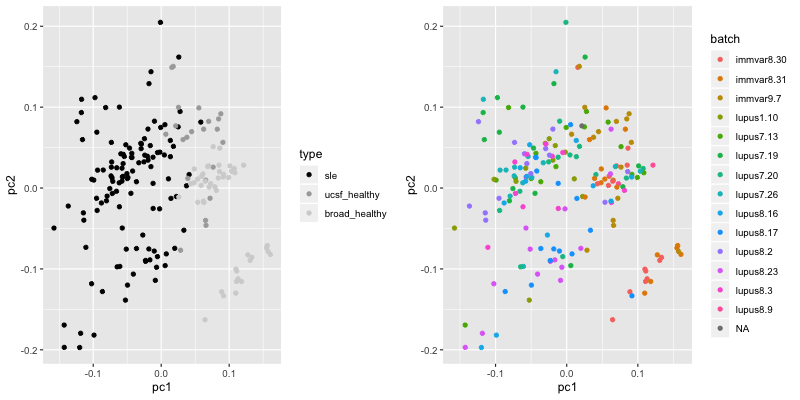

In [14]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 10, repr.plot.height = 5)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

### Check if first PCs correlated with batch and site using standardized data and differentially expressed genes

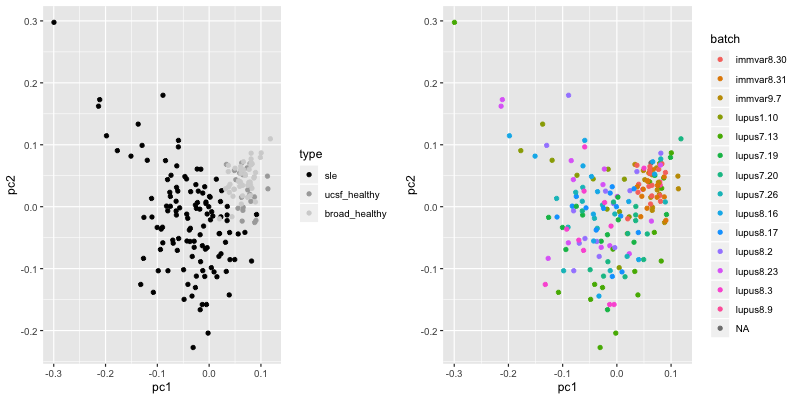

In [15]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(deseq_sig_genes,rownames(pbmc_expr_std))),])

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 10, repr.plot.height = 5)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

### Check if first PCs correlated with batch and site using normalized but not standardized data

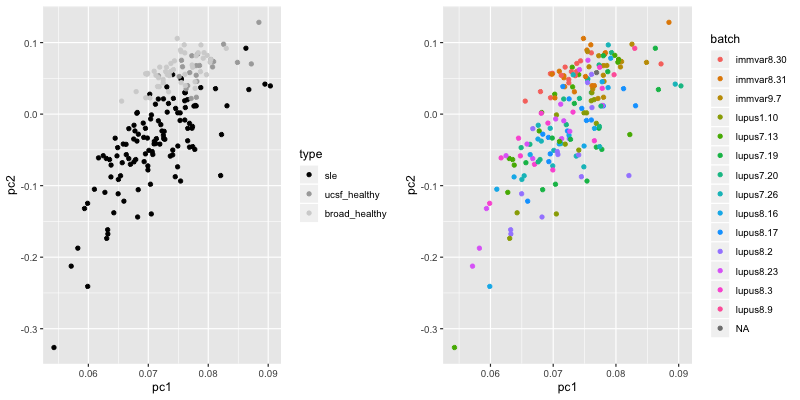

In [16]:
pbmc_expr_prcomp <- prcomp(pbmc_expr)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]


options(repr.plot.width = 10, repr.plot.height = 5)

ggplot_by_disease = ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))
ggplot_by_batch = ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()
grid.arrange(ggplot_by_disease, ggplot_by_batch, ncol=2)

# Load the cell type proportion estimates from joined table

In [17]:
joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")

joined_pivot_sle <- joined_pivot[match(colnames(pbmc_sle_expr), joined_ind_cov_batch),]
joined_pivot_ucsf_healthy <- joined_pivot[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch),]
joined_pivot_broad_healthy <- joined_pivot[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch),]

## Get the cell type proportions

In [18]:
cm_prop = joined_pivot$"cM";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot$"Th";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot$"ncM";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot$"Tc";#/joined_pivot_filtered$pbmc;
cdc_prop = joined_pivot$"cDC";#/joined_pivot_filtered$pbmc;
pdc_prop = joined_pivot$"pDC";#/joined_pivot_filtered$pbmc;

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")

cm_sle_prop = cm_prop[sle_indices]
th_sle_prop = th_prop[sle_indices]
b_sle_prop = b_prop[sle_indices]
nk_sle_prop = nk_prop[sle_indices]
ncm_sle_prop = ncm_prop[sle_indices]
tc_sle_prop = tc_prop[sle_indices]
cdc_sle_prop = cdc_prop[sle_indices]
pdc_sle_prop = pdc_prop[sle_indices]
names(cm_sle_prop) <- names(th_sle_prop) <- names(b_sle_prop) <- names(nk_sle_prop) <- names(ncm_sle_prop) <- names(tc_sle_prop) <- names(cdc_sle_prop) <- names(pdc_sle_prop) <- joined_ind_cov_batch[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]

cm_ucsf_healthy_prop = cm_prop[ucsf_healthy_indices]
th_ucsf_healthy_prop = th_prop[ucsf_healthy_indices]
b_ucsf_healthy_prop = b_prop[ucsf_healthy_indices]
nk_ucsf_healthy_prop = nk_prop[ucsf_healthy_indices]
ncm_ucsf_healthy_prop = ncm_prop[ucsf_healthy_indices]
tc_ucsf_healthy_prop = tc_prop[ucsf_healthy_indices]
cdc_ucsf_healthy_prop = cdc_prop[ucsf_healthy_indices]
pdc_ucsf_healthy_prop = pdc_prop[ucsf_healthy_indices]
names(cm_ucsf_healthy_prop) <- names(th_ucsf_healthy_prop) <- names(b_ucsf_healthy_prop) <- names(nk_ucsf_healthy_prop) <- names(ncm_ucsf_healthy_prop) <- names(tc_ucsf_healthy_prop) <- names(cdc_ucsf_healthy_prop) <- names(pdc_ucsf_healthy_prop)<- joined_ind_cov_batch[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]

cm_broad_healthy_prop = cm_prop[broad_healthy_indices]
th_broad_healthy_prop = th_prop[broad_healthy_indices]
b_broad_healthy_prop = b_prop[broad_healthy_indices]
nk_broad_healthy_prop = nk_prop[broad_healthy_indices]
ncm_broad_healthy_prop = ncm_prop[broad_healthy_indices]
tc_broad_healthy_prop = tc_prop[broad_healthy_indices]
cdc_broad_healthy_prop = cdc_prop[broad_healthy_indices]
pdc_broad_healthy_prop = pdc_prop[broad_healthy_indices]
names(cm_broad_healthy_prop) <- names(th_broad_healthy_prop) <- names(b_broad_healthy_prop) <- names(nk_broad_healthy_prop) <- names(ncm_broad_healthy_prop) <- names(tc_broad_healthy_prop) <- names(cdc_broad_healthy_prop)<- names(pdc_broad_healthy_prop)  <- joined_ind_cov_batch[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]


In [19]:
props <- as.matrix(data.frame(cM=cm_prop, Th=th_prop, B=b_prop, NK=nk_prop, ncM=ncm_prop, Tc=tc_prop, cDC=cdc_prop, pDC=pdc_prop));

props_sle <- as.matrix(data.frame(cM=cm_sle_prop, Th=th_sle_prop, B=b_sle_prop, NK=nk_sle_prop, ncM=ncm_sle_prop, Tc=tc_sle_prop, cDC=cdc_sle_prop, pDC=pdc_sle_prop));
props_ucsf_healthy <- as.matrix(data.frame(cM=cm_ucsf_healthy_prop, Th=th_ucsf_healthy_prop, B=b_ucsf_healthy_prop, NK=nk_ucsf_healthy_prop, ncM=ncm_ucsf_healthy_prop, Tc=tc_ucsf_healthy_prop, cDC=cdc_ucsf_healthy_prop, pDC=pdc_ucsf_healthy_prop));
props_broad_healthy <- as.matrix(data.frame(cM=cm_broad_healthy_prop, Th=th_broad_healthy_prop, B=b_broad_healthy_prop, NK=nk_broad_healthy_prop, ncM=ncm_broad_healthy_prop, Tc=tc_broad_healthy_prop, cDC=cdc_broad_healthy_prop, pDC=pdc_broad_healthy_prop));


## Plot heatmap of proportion and PBMC expression to check batch effects

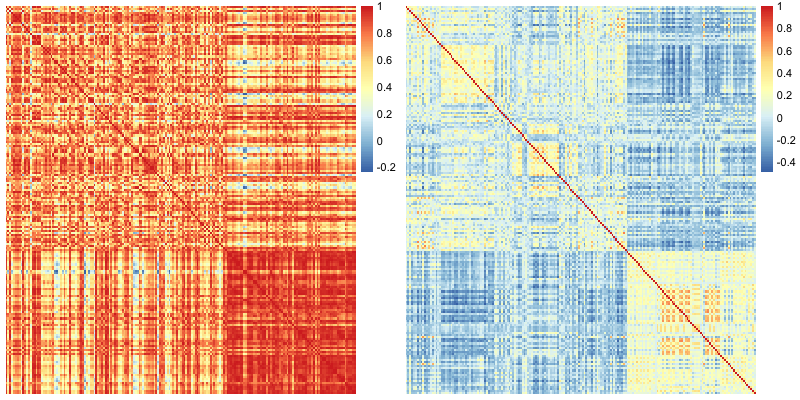

In [20]:
options(repr.plot.width = 10, repr.plot.height = 5)

##par(mfrow=c(1,2))
a=pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, cdc_prop, pdc_prop))),cluster_rows=F,cluster_cols=F, silent=TRUE)
b=pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F, show_colnames=FALSE, show_rownames=FALSE, silent=TRUE)
grid.arrange(arrangeGrob(grobs = list(a[[4]],b[[4]]), ncol=2))


# Let's standardize the data

### Subset data to all samples

In [21]:
exprs_pbmc_counts <- array(c(cm_expr_pbmc_counts, th_expr_pbmc_counts, b_expr_pbmc_counts, nk_expr_pbmc_counts, ncm_expr_pbmc_counts, tc_expr_pbmc_counts, cdc_expr_pbmc_counts, pdc_expr_pbmc_counts),
               c(nrow(cm_expr_pbmc_counts) , ncol(cm_expr_pbmc_counts), 8),
               list(rownames(cm_expr_pbmc_counts),colnames(cm_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_ct_counts <- array(c(cm_expr_ct_counts, th_expr_ct_counts, b_expr_ct_counts, nk_expr_ct_counts, ncm_expr_ct_counts, tc_expr_ct_counts, cdc_expr_ct_counts, pdc_expr_ct_counts),
               c(nrow(cm_expr_ct_counts) , ncol(cm_expr_ct_counts), 8),
               list(rownames(cm_expr_ct_counts),colnames(cm_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))

cm_expr_pbmc_counts_std <- t(apply(cm_expr_pbmc_counts,1,standardize))
th_expr_pbmc_counts_std <- t(apply(th_expr_pbmc_counts,1,standardize))
b_expr_pbmc_counts_std <- t(apply(b_expr_pbmc_counts,1,standardize))
nk_expr_pbmc_counts_std <- t(apply(nk_expr_pbmc_counts,1,standardize))
ncm_expr_pbmc_counts_std <- t(apply(ncm_expr_pbmc_counts,1,standardize))
tc_expr_pbmc_counts_std <- t(apply(tc_expr_pbmc_counts,1,standardize))
cdc_expr_pbmc_counts_std <- t(apply(cdc_expr_pbmc_counts,1,standardize))
pdc_expr_pbmc_counts_std <- t(apply(pdc_expr_pbmc_counts,1,standardize))

cm_expr_ct_counts_std <- t(apply(cm_expr_ct_counts,1,standardize))
th_expr_ct_counts_std <- t(apply(th_expr_ct_counts,1,standardize))
b_expr_ct_counts_std <- t(apply(b_expr_ct_counts,1,standardize))
nk_expr_ct_counts_std <- t(apply(nk_expr_ct_counts,1,standardize))
ncm_expr_ct_counts_std <- t(apply(ncm_expr_ct_counts,1,standardize))
tc_expr_ct_counts_std <- t(apply(tc_expr_ct_counts,1,standardize))
cdc_expr_ct_counts_std <- t(apply(cdc_expr_ct_counts,1,standardize))
pdc_expr_ct_counts_std <- t(apply(pdc_expr_ct_counts,1,standardize))

exprs_pbmc_counts_std <- array(c(cm_expr_pbmc_counts_std, th_expr_pbmc_counts_std, b_expr_pbmc_counts_std, nk_expr_pbmc_counts_std, ncm_expr_pbmc_counts_std, tc_expr_pbmc_counts_std, cdc_expr_pbmc_counts_std, pdc_expr_pbmc_counts_std),
               c(nrow(cm_expr_pbmc_counts_std) , ncol(cm_expr_pbmc_counts_std), 8),
               list(rownames(cm_expr_pbmc_counts_std),colnames(cm_expr_pbmc_counts_std),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_ct_counts_std <- array(c(cm_expr_ct_counts_std, th_expr_ct_counts_std, b_expr_ct_counts_std, nk_expr_ct_counts_std, ncm_expr_ct_counts_std, tc_expr_ct_counts_std, cdc_expr_ct_counts_std, pdc_expr_ct_counts_std),
               c(nrow(cm_expr_ct_counts_std) , ncol(cm_expr_ct_counts_std), 8),
               list(rownames(cm_expr_ct_counts_std),colnames(cm_expr_ct_counts_std),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))


### Subset data to only SLE samples

In [22]:
cm_sle_expr_pbmc_counts <- cm_expr_pbmc_counts[,sle_indices]
th_sle_expr_pbmc_counts <- th_expr_pbmc_counts[,sle_indices]
tc_sle_expr_pbmc_counts <- tc_expr_pbmc_counts[,sle_indices]
ncm_sle_expr_pbmc_counts <- ncm_expr_pbmc_counts[,sle_indices]
b_sle_expr_pbmc_counts <- b_expr_pbmc_counts[,sle_indices]
nk_sle_expr_pbmc_counts <- nk_expr_pbmc_counts[,sle_indices]
cdc_sle_expr_pbmc_counts <- cdc_expr_pbmc_counts[,sle_indices]
pdc_sle_expr_pbmc_counts <- pdc_expr_pbmc_counts[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

cm_sle_expr_ct_counts <- cm_expr_ct_counts[,sle_indices]
th_sle_expr_ct_counts <- th_expr_ct_counts[,sle_indices]
tc_sle_expr_ct_counts <- tc_expr_ct_counts[,sle_indices]
ncm_sle_expr_ct_counts <- ncm_expr_ct_counts[,sle_indices]
b_sle_expr_ct_counts <- b_expr_ct_counts[,sle_indices]
nk_sle_expr_ct_counts <- nk_expr_ct_counts[,sle_indices]
cdc_sle_expr_ct_counts <- cdc_expr_ct_counts[,sle_indices]
pdc_sle_expr_ct_counts <- pdc_expr_ct_counts[,sle_indices]

exprs_sle_pbmc_counts <- array(c(cm_sle_expr_pbmc_counts, th_sle_expr_pbmc_counts, b_sle_expr_pbmc_counts, nk_sle_expr_pbmc_counts, ncm_sle_expr_pbmc_counts, tc_sle_expr_pbmc_counts, cdc_sle_expr_pbmc_counts, pdc_sle_expr_pbmc_counts),
                       c(nrow(cm_sle_expr_pbmc_counts) , ncol(cm_sle_expr_pbmc_counts), 8),
                       list(rownames(cm_sle_expr_pbmc_counts),colnames(cm_sle_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_sle_ct_counts <- array(c(cm_sle_expr_ct_counts, th_sle_expr_ct_counts, b_sle_expr_ct_counts, nk_sle_expr_ct_counts, ncm_sle_expr_ct_counts, tc_sle_expr_ct_counts, cdc_sle_expr_ct_counts, pdc_sle_expr_ct_counts),
                       c(nrow(cm_sle_expr_ct_counts) , ncol(cm_sle_expr_ct_counts), 8),
                       list(rownames(cm_sle_expr_ct_counts),colnames(cm_sle_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_sle_expr_std <- t(apply(pbmc_sle_expr,1,standardize))
cm_sle_expr_pbmc_counts_std <- t(apply(cm_sle_expr_pbmc_counts,1,standardize))
th_sle_expr_pbmc_counts_std <- t(apply(th_sle_expr_pbmc_counts,1,standardize))
b_sle_expr_pbmc_counts_std <- t(apply(b_sle_expr_pbmc_counts,1,standardize))
nk_sle_expr_pbmc_counts_std <- t(apply(nk_sle_expr_pbmc_counts,1,standardize))
ncm_sle_expr_pbmc_counts_std <- t(apply(ncm_sle_expr_pbmc_counts,1,standardize))
tc_sle_expr_pbmc_counts_std <- t(apply(tc_sle_expr_pbmc_counts,1,standardize))
cdc_sle_expr_pbmc_counts_std <- t(apply(cdc_sle_expr_pbmc_counts,1,standardize))
pdc_sle_expr_pbmc_counts_std <- t(apply(pdc_sle_expr_pbmc_counts,1,standardize))

exprs_sle_std_pbmc_counts <- array(c(cm_sle_expr_pbmc_counts_std, th_sle_expr_pbmc_counts_std, b_sle_expr_pbmc_counts_std, nk_sle_expr_pbmc_counts_std, ncm_sle_expr_pbmc_counts_std, tc_sle_expr_pbmc_counts_std, cdc_sle_expr_pbmc_counts_std, pdc_sle_expr_pbmc_counts_std),
                       c(nrow(cm_sle_expr_pbmc_counts) , ncol(cm_sle_expr_pbmc_counts), 8),
                       list(rownames(cm_sle_expr_pbmc_counts),colnames(cm_sle_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

cm_sle_expr_ct_counts_std <- t(apply(cm_sle_expr_ct_counts,1,standardize))
th_sle_expr_ct_counts_std <- t(apply(th_sle_expr_ct_counts,1,standardize))
b_sle_expr_ct_counts_std <- t(apply(b_sle_expr_ct_counts,1,standardize))
nk_sle_expr_ct_counts_std <- t(apply(nk_sle_expr_ct_counts,1,standardize))
ncm_sle_expr_ct_counts_std <- t(apply(ncm_sle_expr_ct_counts,1,standardize))
tc_sle_expr_ct_counts_std <- t(apply(tc_sle_expr_ct_counts,1,standardize))
cdc_sle_expr_ct_counts_std <- t(apply(cdc_sle_expr_ct_counts,1,standardize))
pdc_sle_expr_ct_counts_std <- t(apply(pdc_sle_expr_ct_counts,1,standardize))

exprs_sle_std_ct_counts <- array(c(cm_sle_expr_ct_counts_std, th_sle_expr_ct_counts_std, b_sle_expr_ct_counts_std, nk_sle_expr_ct_counts_std, ncm_sle_expr_ct_counts_std, tc_sle_expr_ct_counts_std, cdc_sle_expr_ct_counts_std, pdc_sle_expr_ct_counts_std),
                       c(nrow(cm_sle_expr_ct_counts) , ncol(cm_sle_expr_ct_counts), 8),
                       list(rownames(cm_sle_expr_ct_counts),colnames(cm_sle_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

### Subset data to healthy controls sequenced at UCSF

In [23]:
cm_ucsf_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]

cm_ucsf_healthy_expr_ct_counts <- cm_expr_ct_counts[,ucsf_healthy_indices]
th_ucsf_healthy_expr_ct_counts <- th_expr_ct_counts[,ucsf_healthy_indices]
tc_ucsf_healthy_expr_ct_counts <- tc_expr_ct_counts[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr_ct_counts <- ncm_expr_ct_counts[,ucsf_healthy_indices]
b_ucsf_healthy_expr_ct_counts <- b_expr_ct_counts[,ucsf_healthy_indices]
nk_ucsf_healthy_expr_ct_counts <- nk_expr_ct_counts[,ucsf_healthy_indices]
cdc_ucsf_healthy_expr_ct_counts <- cdc_expr_ct_counts[,ucsf_healthy_indices]
pdc_ucsf_healthy_expr_ct_counts <- pdc_expr_ct_counts[,ucsf_healthy_indices]

exprs_ucsf_healthy_pbmc_counts <- array(c(cm_ucsf_healthy_expr_pbmc_counts, th_ucsf_healthy_expr_pbmc_counts, b_ucsf_healthy_expr_pbmc_counts, nk_ucsf_healthy_expr_pbmc_counts, ncm_ucsf_healthy_expr_pbmc_counts, tc_ucsf_healthy_expr_pbmc_counts, cdc_ucsf_healthy_expr_pbmc_counts, pdc_ucsf_healthy_expr_pbmc_counts),
                       c(nrow(cm_ucsf_healthy_expr_pbmc_counts) , ncol(cm_ucsf_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_pbmc_counts),colnames(cm_ucsf_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_ucsf_healthy_ct_counts <- array(c(cm_ucsf_healthy_expr_ct_counts, th_ucsf_healthy_expr_ct_counts, b_ucsf_healthy_expr_ct_counts, nk_ucsf_healthy_expr_ct_counts, ncm_ucsf_healthy_expr_ct_counts, tc_ucsf_healthy_expr_ct_counts, cdc_ucsf_healthy_expr_ct_counts, pdc_ucsf_healthy_expr_ct_counts),
                       c(nrow(cm_ucsf_healthy_expr_ct_counts) , ncol(cm_ucsf_healthy_expr_ct_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_ct_counts),colnames(cm_ucsf_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_ucsf_healthy_expr_std <- t(apply(pbmc_ucsf_healthy_expr,1,standardize))
cm_ucsf_healthy_expr_pbmc_counts_std <- t(apply(cm_ucsf_healthy_expr_pbmc_counts,1,standardize))
th_ucsf_healthy_expr_pbmc_counts_std <- t(apply(th_ucsf_healthy_expr_pbmc_counts,1,standardize))
b_ucsf_healthy_expr_pbmc_counts_std <- t(apply(b_ucsf_healthy_expr_pbmc_counts,1,standardize))
nk_ucsf_healthy_expr_pbmc_counts_std <- t(apply(nk_ucsf_healthy_expr_pbmc_counts,1,standardize))
ncm_ucsf_healthy_expr_pbmc_counts_std <- t(apply(ncm_ucsf_healthy_expr_pbmc_counts,1,standardize))
tc_ucsf_healthy_expr_pbmc_counts_std <- t(apply(tc_ucsf_healthy_expr_pbmc_counts,1,standardize))
cdc_ucsf_healthy_expr_pbmc_counts_std <- t(apply(cdc_ucsf_healthy_expr_pbmc_counts,1,standardize))
pdc_ucsf_healthy_expr_pbmc_counts_std <- t(apply(pdc_ucsf_healthy_expr_pbmc_counts,1,standardize))

exprs_ucsf_healthy_std_pbmc_counts <- array(c(cm_ucsf_healthy_expr_pbmc_counts_std, th_ucsf_healthy_expr_pbmc_counts_std, b_ucsf_healthy_expr_pbmc_counts_std, nk_ucsf_healthy_expr_pbmc_counts_std, ncm_ucsf_healthy_expr_pbmc_counts_std, tc_ucsf_healthy_expr_pbmc_counts_std, cdc_ucsf_healthy_expr_pbmc_counts_std, pdc_ucsf_healthy_expr_pbmc_counts_std),
                       c(nrow(cm_ucsf_healthy_expr_pbmc_counts) , ncol(cm_ucsf_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_pbmc_counts),colnames(cm_ucsf_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

cm_ucsf_healthy_expr_ct_counts_std <- t(apply(cm_ucsf_healthy_expr_ct_counts,1,standardize))
th_ucsf_healthy_expr_ct_counts_std <- t(apply(th_ucsf_healthy_expr_ct_counts,1,standardize))
b_ucsf_healthy_expr_ct_counts_std <- t(apply(b_ucsf_healthy_expr_ct_counts,1,standardize))
nk_ucsf_healthy_expr_ct_counts_std <- t(apply(nk_ucsf_healthy_expr_ct_counts,1,standardize))
ncm_ucsf_healthy_expr_ct_counts_std <- t(apply(ncm_ucsf_healthy_expr_ct_counts,1,standardize))
tc_ucsf_healthy_expr_ct_counts_std <- t(apply(tc_ucsf_healthy_expr_ct_counts,1,standardize))
cdc_ucsf_healthy_expr_ct_counts_std <- t(apply(cdc_ucsf_healthy_expr_ct_counts,1,standardize))
pdc_ucsf_healthy_expr_ct_counts_std <- t(apply(pdc_ucsf_healthy_expr_ct_counts,1,standardize))

exprs_ucsf_healthy_std_ct_counts <- array(c(cm_ucsf_healthy_expr_ct_counts_std, th_ucsf_healthy_expr_ct_counts_std, b_ucsf_healthy_expr_ct_counts_std, nk_ucsf_healthy_expr_ct_counts_std, ncm_ucsf_healthy_expr_ct_counts_std, tc_ucsf_healthy_expr_ct_counts_std, cdc_ucsf_healthy_expr_ct_counts_std, pdc_ucsf_healthy_expr_ct_counts_std),
                       c(nrow(cm_ucsf_healthy_expr_ct_counts) , ncol(cm_ucsf_healthy_expr_ct_counts), 8),
                       list(rownames(cm_ucsf_healthy_expr_ct_counts),colnames(cm_ucsf_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))


### Subset data to healthy controls sequenced at the Broad

In [24]:
cm_broad_healthy_expr_pbmc_counts <- cm_expr_pbmc_counts[,broad_healthy_indices]
th_broad_healthy_expr_pbmc_counts <- th_expr_pbmc_counts[,broad_healthy_indices]
tc_broad_healthy_expr_pbmc_counts <- tc_expr_pbmc_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_pbmc_counts <- ncm_expr_pbmc_counts[,broad_healthy_indices]
b_broad_healthy_expr_pbmc_counts <- b_expr_pbmc_counts[,broad_healthy_indices]
nk_broad_healthy_expr_pbmc_counts <- nk_expr_pbmc_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_pbmc_counts <- cdc_expr_pbmc_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_pbmc_counts <- pdc_expr_pbmc_counts[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]

cm_broad_healthy_expr_ct_counts <- cm_expr_ct_counts[,broad_healthy_indices]
th_broad_healthy_expr_ct_counts <- th_expr_ct_counts[,broad_healthy_indices]
tc_broad_healthy_expr_ct_counts <- tc_expr_ct_counts[,broad_healthy_indices]
ncm_broad_healthy_expr_ct_counts <- ncm_expr_ct_counts[,broad_healthy_indices]
b_broad_healthy_expr_ct_counts <- b_expr_ct_counts[,broad_healthy_indices]
nk_broad_healthy_expr_ct_counts <- nk_expr_ct_counts[,broad_healthy_indices]
cdc_broad_healthy_expr_ct_counts <- cdc_expr_ct_counts[,broad_healthy_indices]
pdc_broad_healthy_expr_ct_counts <- pdc_expr_ct_counts[,broad_healthy_indices]

exprs_broad_healthy_pbmc_counts <- array(c(cm_broad_healthy_expr_pbmc_counts, th_broad_healthy_expr_pbmc_counts, b_broad_healthy_expr_pbmc_counts, nk_broad_healthy_expr_pbmc_counts, ncm_broad_healthy_expr_pbmc_counts, tc_broad_healthy_expr_pbmc_counts, cdc_broad_healthy_expr_pbmc_counts, pdc_broad_healthy_expr_pbmc_counts),
                       c(nrow(cm_broad_healthy_expr_pbmc_counts) , ncol(cm_broad_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_broad_healthy_expr_pbmc_counts),colnames(cm_broad_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

exprs_broad_healthy_ct_counts <- array(c(cm_broad_healthy_expr_ct_counts, th_broad_healthy_expr_ct_counts, b_broad_healthy_expr_ct_counts, nk_broad_healthy_expr_ct_counts, ncm_broad_healthy_expr_ct_counts, tc_broad_healthy_expr_ct_counts, cdc_broad_healthy_expr_ct_counts, pdc_broad_healthy_expr_ct_counts),
                       c(nrow(cm_broad_healthy_expr_ct_counts) , ncol(cm_broad_healthy_expr_ct_counts), 8),
                       list(rownames(cm_broad_healthy_expr_ct_counts),colnames(cm_broad_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

pbmc_broad_healthy_expr_std <- t(apply(pbmc_broad_healthy_expr,1,standardize))
cm_broad_healthy_expr_pbmc_counts_std <- t(apply(cm_broad_healthy_expr_pbmc_counts,1,standardize))
th_broad_healthy_expr_pbmc_counts_std <- t(apply(th_broad_healthy_expr_pbmc_counts,1,standardize))
b_broad_healthy_expr_pbmc_counts_std <- t(apply(b_broad_healthy_expr_pbmc_counts,1,standardize))
nk_broad_healthy_expr_pbmc_counts_std <- t(apply(nk_broad_healthy_expr_pbmc_counts,1,standardize))
ncm_broad_healthy_expr_pbmc_counts_std <- t(apply(ncm_broad_healthy_expr_pbmc_counts,1,standardize))
tc_broad_healthy_expr_pbmc_counts_std <- t(apply(tc_broad_healthy_expr_pbmc_counts,1,standardize))
cdc_broad_healthy_expr_pbmc_counts_std <- t(apply(cdc_broad_healthy_expr_pbmc_counts,1,standardize))
pdc_broad_healthy_expr_pbmc_counts_std <- t(apply(pdc_broad_healthy_expr_pbmc_counts,1,standardize))

exprs_broad_healthy_std_pbmc_counts <- array(c(cm_broad_healthy_expr_pbmc_counts_std, th_broad_healthy_expr_pbmc_counts_std, b_broad_healthy_expr_pbmc_counts_std, nk_broad_healthy_expr_pbmc_counts_std, ncm_broad_healthy_expr_pbmc_counts_std, tc_broad_healthy_expr_pbmc_counts_std, cdc_broad_healthy_expr_pbmc_counts_std, pdc_broad_healthy_expr_pbmc_counts_std),
                       c(nrow(cm_broad_healthy_expr_pbmc_counts) , ncol(cm_broad_healthy_expr_pbmc_counts), 8),
                       list(rownames(cm_broad_healthy_expr_pbmc_counts),colnames(cm_broad_healthy_expr_pbmc_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

cm_broad_healthy_expr_ct_counts_std <- t(apply(cm_broad_healthy_expr_ct_counts,1,standardize))
th_broad_healthy_expr_ct_counts_std <- t(apply(th_broad_healthy_expr_ct_counts,1,standardize))
b_broad_healthy_expr_ct_counts_std <- t(apply(b_broad_healthy_expr_ct_counts,1,standardize))
nk_broad_healthy_expr_ct_counts_std <- t(apply(nk_broad_healthy_expr_ct_counts,1,standardize))
ncm_broad_healthy_expr_ct_counts_std <- t(apply(ncm_broad_healthy_expr_ct_counts,1,standardize))
tc_broad_healthy_expr_ct_counts_std <- t(apply(tc_broad_healthy_expr_ct_counts,1,standardize))
cdc_broad_healthy_expr_ct_counts_std <- t(apply(cdc_broad_healthy_expr_ct_counts,1,standardize))
pdc_broad_healthy_expr_ct_counts_std <- t(apply(pdc_broad_healthy_expr_ct_counts,1,standardize))

exprs_broad_healthy_std_ct_counts <- array(c(cm_broad_healthy_expr_ct_counts_std, th_broad_healthy_expr_ct_counts_std, b_broad_healthy_expr_ct_counts_std, nk_broad_healthy_expr_ct_counts_std, ncm_broad_healthy_expr_ct_counts_std, tc_broad_healthy_expr_ct_counts_std, cdc_broad_healthy_expr_ct_counts_std, pdc_broad_healthy_expr_ct_counts_std),
                       c(nrow(cm_broad_healthy_expr_ct_counts) , ncol(cm_broad_healthy_expr_ct_counts), 8),
                       list(rownames(cm_broad_healthy_expr_ct_counts),colnames(cm_broad_healthy_expr_ct_counts),c("cM","Th","B","NK","ncM","Tc","cDC","pDC")))

## Plot heatmap of proportion and standradized PBMC expression to check batch effects

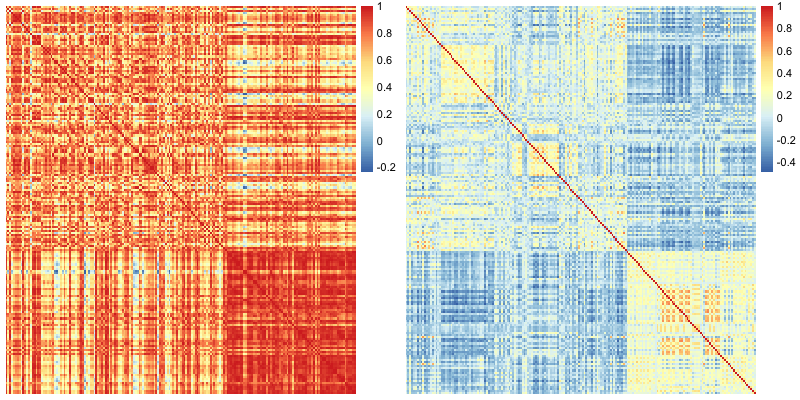

In [25]:
options(repr.plot.width = 10, repr.plot.height = 5)
a = pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, cdc_prop, pdc_prop))),cluster_rows=F,cluster_cols=F,silent=TRUE)
b = pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F, show_colnames=FALSE, show_rownames=FALSE, silent=TRUE)
grid.arrange(arrangeGrob(grobs = list(a[[4]],b[[4]]), ncol=2))

# Figure 2 preparation code

## Cluster the expression data

In [26]:
cell_types <- c("PBMC","cM","ncM", "cDC","pDC","T4","T8","NK","B")

pbmc_col_clust <- hclust(dist(t(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),]),method = "manhattan"), method="ward.D2")
pbmc_row_clust <- hclust(dist(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],method = "manhattan"), method="ward.D2")

all_expr_pbmc_counts_std <- data.frame(pbmc=pbmc_expr_std[,pbmc_col_clust$order],
                                   cm=cm_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   ncm=ncm_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   cdc=cdc_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   pdc=pdc_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   th=th_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   tc=tc_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   nk=nk_expr_pbmc_counts_std[,pbmc_col_clust$order],
                                   b=b_expr_pbmc_counts_std[,pbmc_col_clust$order])


all_expr_pbmc_counts <- data.frame(pbmc=pbmc_expr[,pbmc_col_clust$order],
                      cm=cm_expr_pbmc_counts[,pbmc_col_clust$order],
                      ncm=ncm_expr_pbmc_counts[,pbmc_col_clust$order],
                      cdc=cdc_expr_pbmc_counts[,pbmc_col_clust$order],
                       pdc=pdc_expr_pbmc_counts[,pbmc_col_clust$order],
                      th=th_expr_pbmc_counts[,pbmc_col_clust$order],
                      tc=tc_expr_pbmc_counts[,pbmc_col_clust$order],
                      nk=nk_expr_pbmc_counts[,pbmc_col_clust$order],
                      b=b_expr_pbmc_counts[,pbmc_col_clust$order]
                      )

all_expr_pbmc_counts_sig <- all_expr_pbmc_counts[match(deseq_sig_genes,expr_gene_names),]
all_expr_pbmc_counts_std_sig <- all_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),]
                                       
all_expr_ct_counts_std <- data.frame(pbmc=pbmc_expr_std[,pbmc_col_clust$order],
                                   cm=cm_expr_ct_counts_std[,pbmc_col_clust$order],
                                   ncm=ncm_expr_ct_counts_std[,pbmc_col_clust$order],
                                   cdc=cdc_expr_ct_counts_std[,pbmc_col_clust$order],
                                   pdc=pdc_expr_ct_counts_std[,pbmc_col_clust$order],
                                   th=th_expr_ct_counts_std[,pbmc_col_clust$order],
                                   tc=tc_expr_ct_counts_std[,pbmc_col_clust$order],
                                   nk=nk_expr_ct_counts_std[,pbmc_col_clust$order],
                                   b=b_expr_ct_counts_std[,pbmc_col_clust$order])


all_expr_ct_counts <- data.frame(pbmc=pbmc_expr[,pbmc_col_clust$order],
                      cm=cm_expr_ct_counts[,pbmc_col_clust$order],
                      ncm=ncm_expr_ct_counts[,pbmc_col_clust$order],
                      cdc=cdc_expr_ct_counts[,pbmc_col_clust$order],
                       pdc=pdc_expr_ct_counts[,pbmc_col_clust$order],
                      th=th_expr_ct_counts[,pbmc_col_clust$order],
                      tc=tc_expr_ct_counts[,pbmc_col_clust$order],
                      nk=nk_expr_ct_counts[,pbmc_col_clust$order],
                      b=b_expr_ct_counts[,pbmc_col_clust$order]
                      )

all_expr_ct_counts_sig <- all_expr_ct_counts[match(deseq_sig_genes,expr_gene_names),]
all_expr_ct_counts_std_sig <- all_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),]

ct_annotation_one <- data.frame(disease_pop_cov=joined_pivot$disease_pop_cov,
                           sledaiscore=joined_pivot$sledaiscore)
rownames(ct_annotation_one) <- colnames(pbmc_expr);


ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr_pbmc_counts))),
                           disease_pop_cov=joined_pivot$disease_pop_cov[pbmc_col_clust$order],
                           sledaiscore=joined_pivot$sledaiscore[pbmc_col_clust$order])
rownames(ct_annotation) <- colnames(all_expr_pbmc_counts_std);


## Load the Crow et al. IFN genes

In [27]:
ifn_crow <- read.table("../meta/ifn_lupus_crow_etal.txt")
crow_annotation <- matrix(nrow=nrow(all_expr_pbmc_counts_std_sig), ncol=1, 0);
crow_annotation[na.omit(match(ifn_crow$V1, rownames(all_expr_pbmc_counts_std_sig))),1] <- 1;
rownames(crow_annotation) <- rownames(all_expr_pbmc_counts_std_sig)
colnames(crow_annotation) <- "Crow"
crow_annotation <- as.data.frame(crow_annotation)
sum(crow_annotation$Crow)

[1] 25

## Annotate the PBMC differentially expressed genes

In [28]:
pbmc_deseq_sig_annotation <- matrix(nrow=nrow(all_expr_pbmc_counts_std_sig), ncol=1, 0);
pbmc_deseq_sig_annotation[na.omit(match(pbmc_deseq_sig_genes, rownames(all_expr_pbmc_counts_std_sig))),1] <- 1;
rownames(pbmc_deseq_sig_annotation) <- rownames(all_expr_pbmc_counts_std_sig)
colnames(pbmc_deseq_sig_annotation) <- "PBMC Sig"
pbmc_deseq_sig_annotation <- as.data.frame(pbmc_deseq_sig_annotation)
row_annotations <- cbind(crow_annotation, pbmc_deseq_sig_annotation)
sum(row_annotations$Crow[row_annotations$"PBMC Sig"==1])

[1] 21

## Set colors

In [29]:
annotation_colors = list(
    type = c(PBMC="#000000", cM="#E58606", ncM="#5D69B1", cDC="#52BCA3", pDC="#99C945", T4="#CC61B0", T8="#24796C", NK="#DAA51B", B="#764E9F"),
    disease_pop_cov = c(healthyWHITE="#D82B29", sleWHITE="#1B78B6", sleASIAN="#F57F20")
)


## Figure 2A: Make volcano plots

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

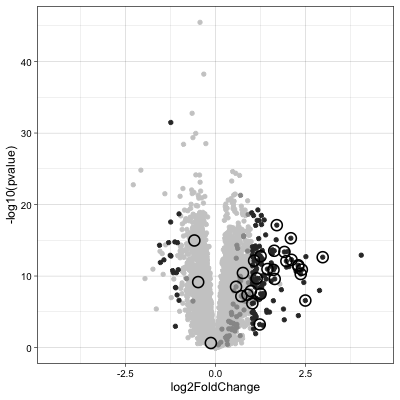

In [30]:
options(repr.plot.width = 5, repr.plot.height = 5)
pbmc_deseq$ifn=pbmc_deseq$V1 %in% ifn_crow$V1
pbmc_deseq$sig=rep("cnot significant",nrow(pbmc_deseq))
pbmc_deseq$sig[match(deseq_sig_genes, pbmc_deseq$V1)]="bct_sig";
pbmc_deseq$sig[match(pbmc_deseq_sig_genes, pbmc_deseq$V1)]="apbmc_sig";

pbmc_deseq <- pbmc_deseq[order(pbmc_deseq$sig,decreasing=T),]
# !(abs(pbmc_deseq$log2FoldChange)>1) & (which(pbmc_deseq$qval < 0.01))

lim=max(abs(pbmc_deseq$log2FoldChange)) + 0.2
min_lim=-lim

##pdf(paste(ct, '.volcano.pdf', sep=''), useDingbats=F)
g = ggplot(pbmc_deseq, aes(x=log2FoldChange, y=-log10(pvalue), color=sig))+ theme_linedraw()+theme(legend.position="none") + xlim(-4.5, 4.5) + geom_point()+geom_point(data=pbmc_deseq[pbmc_deseq$ifn,],
             pch=21, fill=NA, size=4, colour="black", stroke=1)+scale_color_grey()+scale_fill_grey()
ggsave(g, filename=paste(fig_dir,"/pbmc_deseq.png",sep=""), width=3, height=3, dpi=300)
##dev.off()
plot(g)

## Figure 2C: Make heatmap

In [31]:
# options(repr.plot.width = 5, repr.plot.height = 5)
# breaksList = seq(-2, 2, by = .1)


# mat <- t(as.matrix(apply(all_expr_pbmc_counts_std_sig,1,function(x) {(x-mean(x))/sd(x)})));
# mat[which(mat > 2)] = 2;
# mat[which(mat < -2)] = -2;

# pheatmap_std_out <- pheatmap(mat,
#          cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,#annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
#                          cutree_rows=8, 
#                          scale="none",fontsize=5,clustering_method="complete",clustering_distance_row="manhattan",
#                             width=10, height=10)


## First, let's run clustering using pheatmap and save the ordering of genes

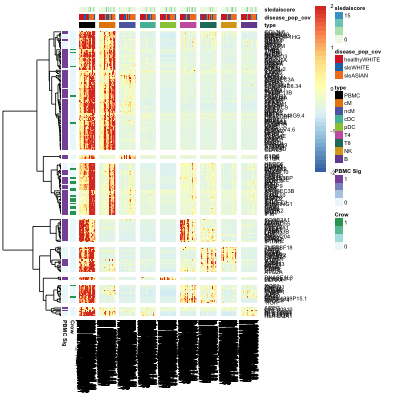

In [32]:
options(repr.plot.width = 5, repr.plot.height = 5)
breaksList = seq(-2, 2, by = .1)

mat <- t(as.matrix(apply(all_expr_pbmc_counts_sig,1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;

pheatmap_pbmc_counts_out <- pheatmap(mat,
         cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,#annotation_row = kmeans_annotation,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
                         cutree_rows=8, 
                         scale="none",fontsize=5,clustering_method="ward.D2",clustering_distance_row="correlation",
                            width=10, height=10)

## Now, let's order the clusters and annotate them

In [33]:
cuttree_out_unordered <- cutree(pheatmap_pbmc_counts_out$tree_row, k = 8)
t(unique(cuttree_out_unordered[pheatmap_pbmc_counts_out$tree_row$order]))

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,] 2    6    4    1    5    3    8    7

In [34]:
cuttree_out_unordered[which(cuttree_out_unordered==6)] <- "ncM";
cuttree_out_unordered[which(cuttree_out_unordered==3)] <- "pDC";
cuttree_out_unordered[which(cuttree_out_unordered==7)] <- "B";
cuttree_out_unordered[which(cuttree_out_unordered==4)] <- "Pan";
cuttree_out_unordered[which(cuttree_out_unordered==2)] <- "Mono";
cuttree_out_unordered[which(cuttree_out_unordered==5)] <- "T8";
cuttree_out_unordered[which(cuttree_out_unordered==1)] <- "T4";
cuttree_out_unordered[which(cuttree_out_unordered==8)] <- "Lymph";

cuttree_out_unordered <- factor(cuttree_out_unordered, levels=c("Pan","Mono","ncM","pDC","T4","T8","Lymph","B"), ordered=T)
cuttree_out <- cuttree_out_unordered[order(cuttree_out_unordered)];

cuttree_gene_names <- names(cuttree_out);
cuttree_out <- data.frame(cuttree_gene_names,cuttree_out)
colnames(cuttree_out) <- c("gene","cluster")
cuttree_out <- as.data.frame(cuttree_out);
cuttree_out[,"gene"] <- as.character(cuttree_out[,"gene"])
write.table(cuttree_out, file="diffexp_annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

## Plot normalized by PBMC counts (main figure)

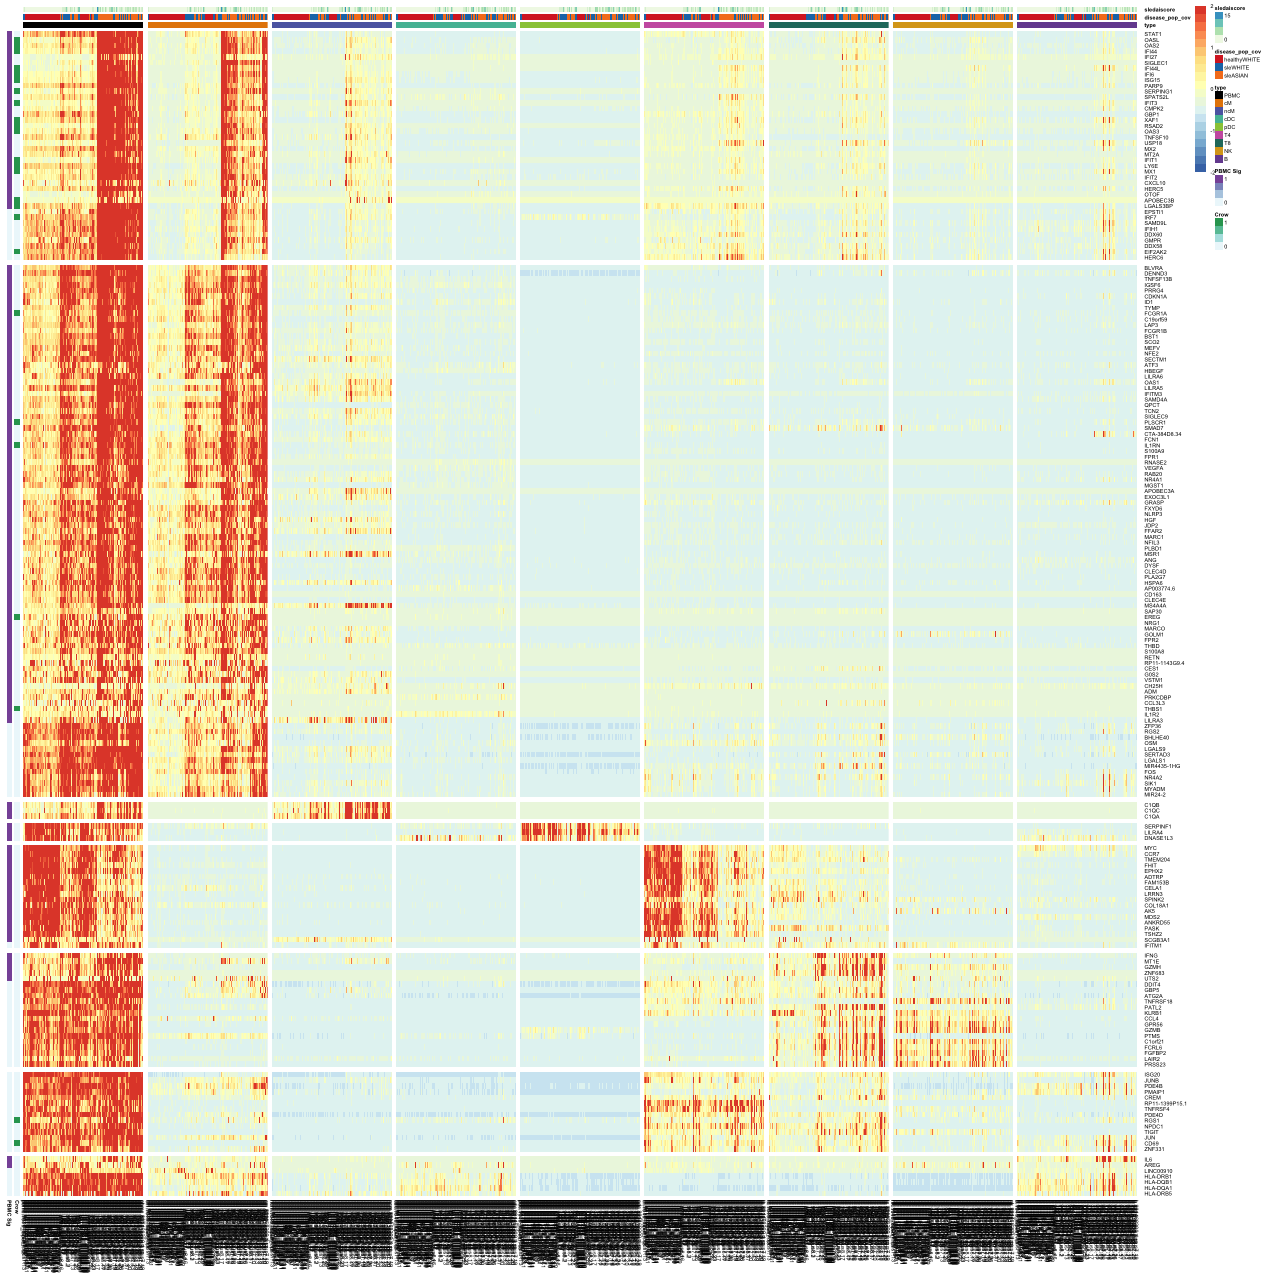

In [35]:
options(repr.plot.width = 16, repr.plot.height = 16)
min = -2;
max = 2;
breaksList = c(seq(-2, 2, by = .2))

mat <- t(as.matrix(apply(all_expr_pbmc_counts_sig[cuttree_out$gene,],1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;

pheatmap_pbmc_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
        gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                         scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")

pheatmap_pbmc_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_pbmc_counts),ncol(cm_expr_pbmc_counts)*length(cell_types),ncol(cm_expr_pbmc_counts)),
      gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                   scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",filename=paste(fig_dir,"/expr_pbmc_counts_heatmap.png",sep=""))


options(repr.plot.width = 10, repr.plot.height = 4)

## Plot normalized by cell type specific counts (supp figure)

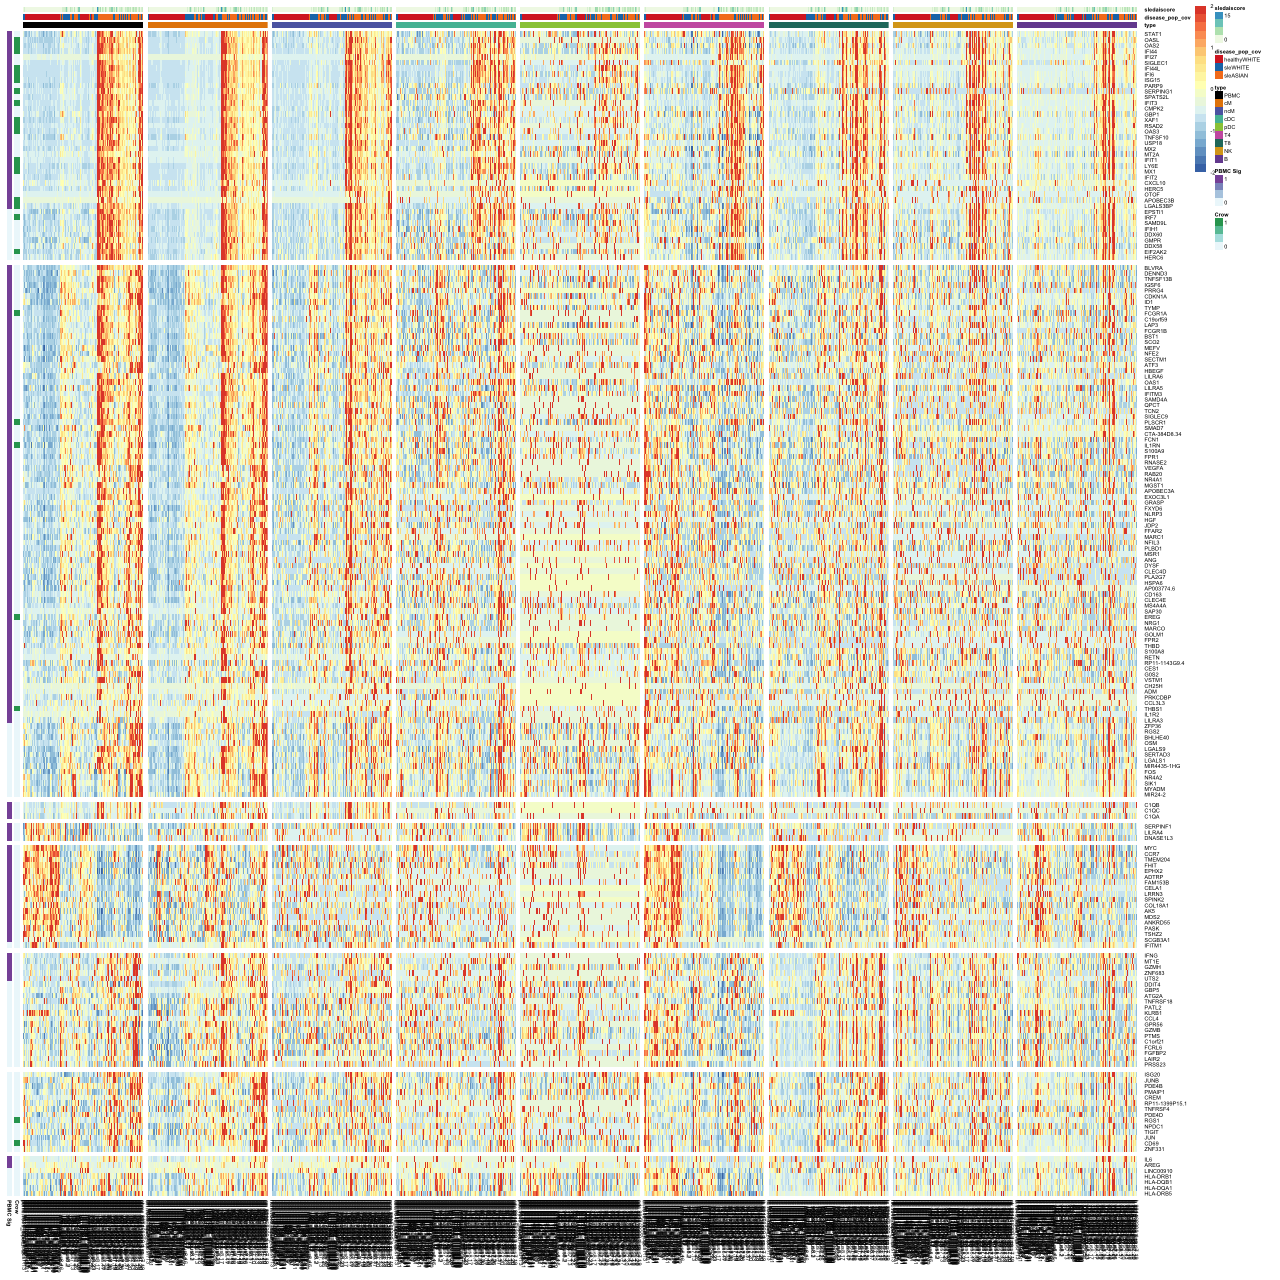

In [36]:
options(repr.plot.width = 16, repr.plot.height = 16)
breaksList = seq(-2, 2, by = .2)


mat <- t(as.matrix(apply(all_expr_pbmc_counts_std_sig[cuttree_out$gene,],1,function(x) {(x-mean(x))/sd(x)})));
mat[which(mat > 2)] = 2;
mat[which(mat < -2)] = -2;


pheatmap_ct_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
                         gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                         scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan")

pheatmap_ct_counts_out <- pheatmap(mat,
         cluster_rows=F, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, annotation_colors=annotation_colors,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr_ct_counts),ncol(cm_expr_ct_counts)*length(cell_types),ncol(cm_expr_ct_counts)),
                         gaps_row=(which(!duplicated(cuttree_out$cluster))-1)[-1],
                         scale="none",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",filename=paste(fig_dir,"/expr_ct_counts_heatmap.png",sep=""))
options(repr.plot.width = 10, repr.plot.height = 4)

# Calculate proportion of variance explained


First, we are going to estimate proportion of variance explained by cell type proportion

This will be a multiple regression

\begin{equation*}
e_i = -1 + b_1\times p_1 + b_2\times p_2 + ... + b_n\times p_n
\end{equation*}

Next, we are going to estimate proportion of variance explained by cell type specific expression

This will be a multiple regression


\begin{equation*}
e_i = -1 + b_1\times e_1 + b_2\times e_2 + ... + b_n\times e_n
\end{equation*}

calculate adjusted r_2 and also the cell type specific r2

Y_i = %mono*mono_i + %other*other_i + err
Or
Y_i = %mono*mono_i
log(Y_i) = log(%mono)+log(mono_i)+err


## Processing all

In [37]:
output_prop_expr_noint <- model_prop_expr_noah(pbmc_expr, props, exprs_pbmc_counts);

output_prop_noint <- output_prop_expr_noint[[1]];
output_expr_noint <- output_prop_expr_noint[[4]];
output_expr_pbmc_count_noint <- output_prop_expr_noint[[7]];


## Processing SLE

In [38]:
output_sle_prop_expr_noint <- model_prop_expr_noah(pbmc_sle_expr, props_sle, exprs_sle_pbmc_counts);

output_sle_prop_noint <- output_sle_prop_expr_noint[[1]];
output_sle_expr_noint <- output_sle_prop_expr_noint[[4]];
output_sle_expr_pbmc_count_noint <- output_sle_prop_expr_noint[[7]];

## Processing SLE to 46 samples

In [39]:
samples_asian <- which(joined_pivot$disease_pop_cov=="sleASIAN")
samples_white <- which(joined_pivot$disease_pop_cov=="sleWHITE")

output_sle_asian_prop_expr_noint <- model_prop_expr_noah(pbmc_expr[,samples_asian], props[samples_asian,], exprs_pbmc_counts[,samples_asian,]);
output_sle_asian_prop_noint <- output_sle_asian_prop_expr_noint[[1]];
output_sle_asian_expr_noint <- output_sle_asian_prop_expr_noint[[4]];
output_sle_asian_expr_pbmc_count_noint <- output_sle_asian_prop_expr_noint[[7]];

output_sle_white_prop_expr_noint <- model_prop_expr_noah(pbmc_expr[,samples_white], props[samples_white,], exprs_pbmc_counts[,samples_white,]);
output_sle_white_prop_noint <- output_sle_white_prop_expr_noint[[1]];
output_sle_white_expr_noint <- output_sle_white_prop_expr_noint[[4]];
output_sle_white_expr_pbmc_count_noint <- output_sle_white_prop_expr_noint[[7]];


## Processing UCSF healthy

In [40]:
output_ucsf_healthy_prop_expr_noint <- model_prop_expr_noah(pbmc_ucsf_healthy_expr, props_ucsf_healthy, exprs_ucsf_healthy_pbmc_counts);

output_ucsf_healthy_prop_noint <- output_ucsf_healthy_prop_expr_noint[[1]]
output_ucsf_healthy_expr_noint <- output_ucsf_healthy_prop_expr_noint[[4]]
output_ucsf_healthy_expr_pbmc_count_noint <- output_ucsf_healthy_prop_expr_noint[[7]]

## Processing Broad healthy

In [41]:
output_broad_healthy_prop_expr_noint <- model_prop_expr_noah(pbmc_broad_healthy_expr, props_broad_healthy, exprs_broad_healthy_pbmc_counts);

output_broad_healthy_prop_noint <- output_broad_healthy_prop_expr_noint[[1]];
output_broad_healthy_expr_noint <- output_broad_healthy_prop_expr_noint[[4]];
output_broad_healthy_expr_pbmc_count_noint <- output_broad_healthy_prop_expr_noint[[7]];


## Summarize and plotting results

### Total r2

Warning message:
“Removed 6 rows containing missing values (geom_point).”

cor        prop_mean expr_mean sum_mean
all           -0.9442940 25.29800  71.17303  96.47103
sle           -0.9156828 22.10258  73.55738  95.65997
sle_asian     -0.9064034 25.27904  70.43819  95.71723
sle_white     -0.9478335 28.77341  67.92656  96.69997
ucsf_healthy  -0.9543947 42.77459  55.95788  98.73246
broad_healthy -0.9530784 29.87880  68.19380  98.07260

cM        Th         B         NK        ncM      Tc       
all_prop            8.129979  1.7498514  2.993949  2.312562 2.253928  1.566920
all_expr           17.879414 18.5076205  9.054319  5.328997 4.696807 12.238965
sle_prop            6.566649  1.4589947  3.797984  2.550183 2.434316  2.292094
sle_expr           21.748183 15.6676622  8.972643  5.318018 5.479772 13.208294
sle_asian_prop      5.928604  3.0962470  4.000054  2.401635 2.848174  2.888214
sle_asian_expr     20.685845 13.2687506 10.021892  4.720952 4.811329 13.827599
sle_white_prop      8.451079  1.6877477  3.944227  5.193980 3.382784  1.763964
sle_white_expr     20.098679 16.3169047  6.592481  5.443748 5.573757 10.870458
ucsf_healthy_prop   7.612394  0.6308150  5.073758 10.143063 5.453517  3.913944
ucsf_healthy_expr   9.492645 19.4274740  6.318271  4.443335 3.202062  9.248473
broad_healthy_prop  8.895743 -0.2113701  4.510104  5.244369 2.986434  2.046417
broad_healthy_expr 12.900158 21.3731406  9.348086  5.496471 3.981324 11.136378
                   cDC      pDC       total.r2 adj.r2   total.prop_expr.r2
all_prop           1.056004 5.2348091 25.29800 21.94061 96.47103          
all_expr           2.406335 1.0605751 71.17303 69.87744 96.47103          
sle_prop           1.850604 1.1517575 22.10258 16.38534 95.65997          
sle_expr           2.386991 0.7758208 73.55738 71.61664 95.65997          
sle_asian_prop     2.294761 1.8213507 25.27904 14.00040 95.71723          
sle_asian_expr     2.297349 0.8044777 70.43819 65.97603 95.71723          
sle_white_prop     2.283701 2.0659304 28.77341 16.64974 96.69997          
sle_white_expr     2.224699 0.8058320 67.92656 62.46725 96.69997          
ucsf_healthy_prop  5.144307 4.8027896 42.77459  7.55895 98.73246          
ucsf_healthy_expr  2.441248 1.3843680 55.95788 28.85503 98.73246          
broad_healthy_prop 1.896990 4.5101129 29.87880 15.11644 98.07260          
broad_healthy_expr 2.404963 1.5532839 68.19380 61.49776 98.07260          
                   adj.prop_expr.r2
all_prop           91.81805        
all_expr           91.81805        
sle_prop           88.00198        
sle_expr           88.00198        
sle_asian_prop     79.97644        
sle_asian_expr     79.97644        
sle_white_prop     79.11699        
sle_white_expr     79.11699        
ucsf_healthy_prop  36.41398        
ucsf_healthy_expr  36.41398        
broad_healthy_prop 76.61421        
broad_healthy_expr 76.61421

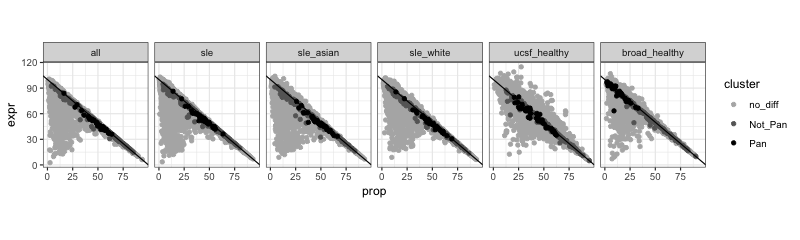

In [42]:
output_noint_df <- data.frame(prop=output_prop_noint[,"total r2"], expr=output_expr_noint[,"total r2"], type="all")
output_noint_df$cluster <- "no_diff";
output_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_noint_df <- data.frame(prop=output_sle_prop_noint[,"total r2"], expr=output_sle_expr_noint[,"total r2"], type="sle")
output_sle_noint_df$cluster <- "no_diff";
output_sle_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_asian_noint_df <- data.frame(prop=output_sle_asian_prop_noint[,"total r2"], expr=output_sle_asian_expr_noint[,"total r2"], type="sle_asian")
output_sle_asian_noint_df$cluster <- "no_diff";
output_sle_asian_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_asian_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_white_noint_df <- data.frame(prop=output_sle_white_prop_noint[,"total r2"], expr=output_sle_white_expr_noint[,"total r2"], type="sle_white")
output_sle_white_noint_df$cluster <- "no_diff";
output_sle_white_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_white_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_ucsf_healthy_noint_df <- data.frame(prop=output_ucsf_healthy_prop_noint[,"total r2"], expr=output_ucsf_healthy_expr_noint[,"total r2"], type="ucsf_healthy")
output_ucsf_healthy_noint_df$cluster <- "no_diff";
output_ucsf_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_broad_healthy_noint_df <- data.frame(prop=output_broad_healthy_prop_noint[,"total r2"], expr=output_broad_healthy_expr_noint[,"total r2"], type="broad_healthy")
output_broad_healthy_noint_df$cluster <- "no_diff";
output_broad_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

df <- rbind(output_noint_df, output_sle_noint_df, 
            output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_ucsf_healthy_noint_df, output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 10, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "Pan")] <- "Not_Pan";
df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","Not_Pan","Pan"));
df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

df2 <- data.frame(cor=c(cor(output_prop_noint[,"total r2"], output_expr_noint[,"total r2"]),
                        cor(output_sle_prop_noint[,"total r2"], output_sle_expr_noint[,"total r2"]),
                        cor(output_sle_asian_prop_noint[,"total r2"], output_sle_asian_expr_noint[,"total r2"]),
                        cor(output_sle_white_prop_noint[,"total r2"], output_sle_white_expr_noint[,"total r2"], use='complete.obs'),
                        cor(output_ucsf_healthy_prop_noint[,"total r2"], output_ucsf_healthy_expr_noint[,"total r2"], use='complete.obs'),
                        cor(output_broad_healthy_prop_noint[,"total r2"], output_broad_healthy_expr_noint[,"total r2"], use='complete.obs')),
                  prop_mean=c(mean(output_prop_noint[,"total r2"]), mean(output_sle_prop_noint[,"total r2"]),
                              mean(output_sle_asian_prop_noint[,"total r2"]), mean(output_sle_white_prop_noint[,"total r2"], na.rm=T),
                              mean(output_ucsf_healthy_prop_noint[,"total r2"],na.rm=T), mean(output_broad_healthy_prop_noint[,"total r2"], na.rm=T)),
                  expr_mean=c(mean(output_expr_noint[,"total r2"]), mean(output_sle_expr_noint[,"total r2"]),
                              mean(output_sle_asian_expr_noint[,"total r2"]), mean(output_sle_white_expr_noint[,"total r2"],na.rm=T),
                              mean(output_ucsf_healthy_expr_noint[,"total r2"],na.rm=T), mean(output_broad_healthy_expr_noint[,"total r2"],na.rm=T)),
                  sum_mean = c(mean(output_prop_noint[,"total r2"]+output_expr_noint[,"total r2"]), 
                               mean(output_sle_prop_noint[,"total r2"]+output_sle_expr_noint[,"total r2"]), 
                               mean(output_sle_asian_prop_noint[,"total r2"]+output_sle_asian_expr_noint[,"total r2"]), 
                               mean(output_sle_white_prop_noint[,"total r2"]+output_sle_white_expr_noint[,"total r2"],na.rm=T), 
                               mean(output_ucsf_healthy_prop_noint[,"total r2"]+output_ucsf_healthy_expr_noint[,"total r2"],na.rm=T),
                               mean(output_broad_healthy_prop_noint[,"total r2"]+output_broad_healthy_expr_noint[,"total r2"],na.rm=T)))
rownames(df2) <- c("all", "sle", "sle_asian","sle_white", "ucsf_healthy", "broad_healthy")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_expr_noint,2,mean,na.rm=T))))

rownames(df3) <- c("all_prop", "all_expr", "sle_prop", "sle_expr", 
                   "sle_asian_prop", "sle_asian_expr", "sle_white_prop", "sle_white_expr", 
                   "ucsf_healthy_prop", "ucsf_healthy_expr","broad_healthy_prop", "broad_healthy_expr")

df3

### Adjusted r2

Warning message:
“Removed 6 rows containing missing values (geom_point).”

cor        prop_mean expr_mean sum_mean
all           -0.9442940 21.94061  69.87744  91.81805
sle           -0.9156828 16.38534  71.61664  88.00198
sle_asian     -0.9064034 14.00040  65.97603  79.97644
sle_white     -0.9478335 16.64974  62.46725  79.11699
ucsf_healthy  -0.9543947  7.55895  28.85503  36.41398
broad_healthy -0.9530784 15.11644  61.49776  76.61421

cM        Th         B         NK        ncM      Tc       
all_prop            8.129979  1.7498514  2.993949  2.312562 2.253928  1.566920
all_expr           17.879414 18.5076205  9.054319  5.328997 4.696807 12.238965
sle_prop            6.566649  1.4589947  3.797984  2.550183 2.434316  2.292094
sle_expr           21.748183 15.6676622  8.972643  5.318018 5.479772 13.208294
sle_asian_prop      5.928604  3.0962470  4.000054  2.401635 2.848174  2.888214
sle_asian_expr     20.685845 13.2687506 10.021892  4.720952 4.811329 13.827599
sle_white_prop      8.451079  1.6877477  3.944227  5.193980 3.382784  1.763964
sle_white_expr     20.098679 16.3169047  6.592481  5.443748 5.573757 10.870458
ucsf_healthy_prop   7.612394  0.6308150  5.073758 10.143063 5.453517  3.913944
ucsf_healthy_expr   9.492645 19.4274740  6.318271  4.443335 3.202062  9.248473
broad_healthy_prop  8.895743 -0.2113701  4.510104  5.244369 2.986434  2.046417
broad_healthy_expr 12.900158 21.3731406  9.348086  5.496471 3.981324 11.136378
                   cDC      pDC       total.r2 adj.r2   total.prop_expr.r2
all_prop           1.056004 5.2348091 25.29800 21.94061 96.47103          
all_expr           2.406335 1.0605751 71.17303 69.87744 96.47103          
sle_prop           1.850604 1.1517575 22.10258 16.38534 95.65997          
sle_expr           2.386991 0.7758208 73.55738 71.61664 95.65997          
sle_asian_prop     2.294761 1.8213507 25.27904 14.00040 95.71723          
sle_asian_expr     2.297349 0.8044777 70.43819 65.97603 95.71723          
sle_white_prop     2.283701 2.0659304 28.77341 16.64974 96.69997          
sle_white_expr     2.224699 0.8058320 67.92656 62.46725 96.69997          
ucsf_healthy_prop  5.144307 4.8027896 42.77459  7.55895 98.73246          
ucsf_healthy_expr  2.441248 1.3843680 55.95788 28.85503 98.73246          
broad_healthy_prop 1.896990 4.5101129 29.87880 15.11644 98.07260          
broad_healthy_expr 2.404963 1.5532839 68.19380 61.49776 98.07260          
                   adj.prop_expr.r2
all_prop           91.81805        
all_expr           91.81805        
sle_prop           88.00198        
sle_expr           88.00198        
sle_asian_prop     79.97644        
sle_asian_expr     79.97644        
sle_white_prop     79.11699        
sle_white_expr     79.11699        
ucsf_healthy_prop  36.41398        
ucsf_healthy_expr  36.41398        
broad_healthy_prop 76.61421        
broad_healthy_expr 76.61421

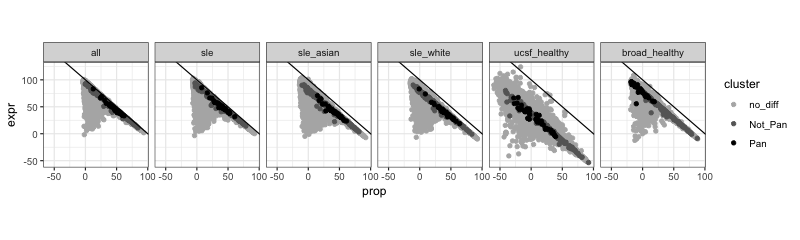

In [43]:
output_noint_df <- data.frame(prop=output_prop_noint[,"adj r2"], expr=output_expr_noint[,"adj r2"], type="all")
output_noint_df$cluster <- "no_diff";
output_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_noint_df <- data.frame(prop=output_sle_prop_noint[,"adj r2"], expr=output_sle_expr_noint[,"adj r2"], type="sle")
output_sle_noint_df$cluster <- "no_diff";
output_sle_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_asian_noint_df <- data.frame(prop=output_sle_asian_prop_noint[,"adj r2"], expr=output_sle_asian_expr_noint[,"adj r2"], type="sle_asian")
output_sle_asian_noint_df$cluster <- "no_diff";
output_sle_asian_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_asian_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_sle_white_noint_df <- data.frame(prop=output_sle_white_prop_noint[,"adj r2"], expr=output_sle_white_expr_noint[,"adj r2"], type="sle_white")
output_sle_white_noint_df$cluster <- "no_diff";
output_sle_white_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_white_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_ucsf_healthy_noint_df <- data.frame(prop=output_ucsf_healthy_prop_noint[,"adj r2"], expr=output_ucsf_healthy_expr_noint[,"adj r2"], type="ucsf_healthy")
output_ucsf_healthy_noint_df$cluster <- "no_diff";
output_ucsf_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

output_broad_healthy_noint_df <- data.frame(prop=output_broad_healthy_prop_noint[,"adj r2"], expr=output_broad_healthy_expr_noint[,"adj r2"], type="broad_healthy")
output_broad_healthy_noint_df$cluster <- "no_diff";
output_broad_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_df))] <- as.character(cuttree_out[,"cluster"]);

df <- rbind(output_noint_df, output_sle_noint_df, 
            output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_ucsf_healthy_noint_df, output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 10, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "Pan")] <- "Not_Pan";
df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","Not_Pan","Pan"));
df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]),
                        cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]),
                        cor(output_sle_asian_prop_noint[,"adj r2"], output_sle_asian_expr_noint[,"adj r2"]),
                        cor(output_sle_white_prop_noint[,"adj r2"], output_sle_white_expr_noint[,"adj r2"], use='complete.obs'),
                        cor(output_ucsf_healthy_prop_noint[,"adj r2"], output_ucsf_healthy_expr_noint[,"adj r2"], use='complete.obs'),
                        cor(output_broad_healthy_prop_noint[,"adj r2"], output_broad_healthy_expr_noint[,"adj r2"], use='complete.obs')),
                  prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]),
                              mean(output_sle_asian_prop_noint[,"adj r2"]), mean(output_sle_white_prop_noint[,"adj r2"], na.rm=T),
                              mean(output_ucsf_healthy_prop_noint[,"adj r2"],na.rm=T), mean(output_broad_healthy_prop_noint[,"adj r2"], na.rm=T)),
                  expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]),
                              mean(output_sle_asian_expr_noint[,"adj r2"]), mean(output_sle_white_expr_noint[,"adj r2"],na.rm=T),
                              mean(output_ucsf_healthy_expr_noint[,"adj r2"],na.rm=T), mean(output_broad_healthy_expr_noint[,"adj r2"],na.rm=T)),
                  sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), 
                               mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), 
                               mean(output_sle_asian_prop_noint[,"adj r2"]+output_sle_asian_expr_noint[,"adj r2"]), 
                               mean(output_sle_white_prop_noint[,"adj r2"]+output_sle_white_expr_noint[,"adj r2"],na.rm=T), 
                               mean(output_ucsf_healthy_prop_noint[,"adj r2"]+output_ucsf_healthy_expr_noint[,"adj r2"],na.rm=T),
                               mean(output_broad_healthy_prop_noint[,"adj r2"]+output_broad_healthy_expr_noint[,"adj r2"],na.rm=T)))
rownames(df2) <- c("all", "sle", "sle_asian","sle_white", "ucsf_healthy", "broad_healthy")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_expr_noint,2,mean,na.rm=T))))

rownames(df3) <- c("all_prop", "all_expr", "sle_prop", "sle_expr", 
                   "sle_asian_prop", "sle_asian_expr", "sle_white_prop", "sle_white_expr", 
                   "ucsf_healthy_prop", "ucsf_healthy_expr","broad_healthy_prop", "broad_healthy_expr")

df3

# Figure 2C: Distribution of r2 per population

In [44]:
df <- rbind(output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 3, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster2 <- as.character(df_all_ifn$cluster);


Warning message:
“Removed 4205 rows containing non-finite values (stat_density).”Warning message:
“Removed 4205 rows containing non-finite values (stat_density).”Warning message:
“Removed 3650 rows containing non-finite values (stat_density).”Warning message:
“Removed 3650 rows containing non-finite values (stat_density).”Warning message:
“Removed 3901 rows containing non-finite values (stat_density).”Warning message:
“Removed 3901 rows containing non-finite values (stat_density).”Warning message:
“Removed 4205 rows containing non-finite values (stat_density).”Warning message:
“Removed 3650 rows containing non-finite values (stat_density).”Warning message:
“Removed 3901 rows containing non-finite values (stat_density).”Warning message:
“Removed 4205 rows containing non-finite values (stat_density).”Warning message:
“Removed 3650 rows containing non-finite values (stat_density).”Warning message:
“Removed 3901 rows containing non-finite values (stat_density).”

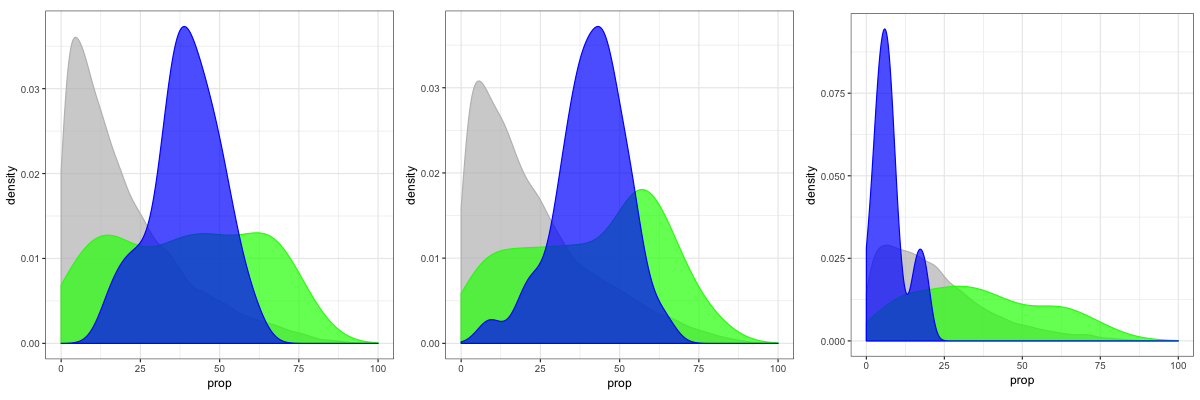

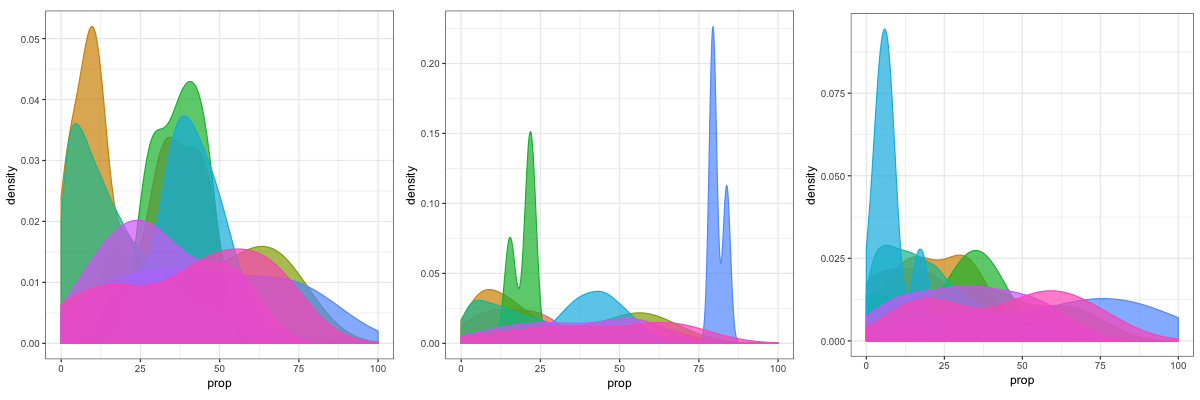

In [45]:
df <- rbind(output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 15, repr.plot.height = 5)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);

df_all_ifn$cluster2 <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster2[which(df_all_ifn$cluster2 != "no_diff" & df_all_ifn$cluster == "Pan")] <- "pan";
df_all_ifn$cluster2[which(df_all_ifn$cluster2 != "no_diff" & df_all_ifn$cluster != "Pan")] <- "no_pan";
df_all_ifn$cluster2 <- factor(df_all_ifn$cluster2, levels=c("no_diff","no_pan","pan"));

df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]

sle_asian_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))
ggsave(paste(fig_dir,"/sle_asian_diff_no_diff_histogram.png",sep=""), sle_asian_p, dpi=300, height=3, width=3)

sle_asian_cluster_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave(paste(fig_dir,"/sle_asian_cluster_histogram.png",sep=""), sle_asian_cluster_p, dpi=300, height=3, width=3)

sle_white_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))##+scale_color_manual(values=c("gray70", "black"))+scale_fill_manual(values=c("gray70", "black"))
ggsave(paste(fig_dir,"/sle_white_diff_no_diff_histogram.png",sep=""), sle_white_p, dpi=300, height=3, width=3)

sle_white_cluster_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave(paste(fig_dir,"/sle_white_cluster_histogram.png",sep=""), sle_white_cluster_p, dpi=300, height=3, width=3)

broad_white_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))##+scale_color_manual(values=c("gray70", "black"))+scale_fill_manual(values=c("gray70", "black"))
ggsave(paste(fig_dir,"/broad_white_diff_no_diff_histogram.png",sep=""), broad_white_p, dpi=300, height=3, width=3)


broad_white_cluster_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave(paste(fig_dir,"/broad_white_cluster_histogram.png",sep=""), broad_white_cluster_p, dpi=300, height=3, width=3)

grid.arrange(sle_asian_p, sle_white_p, broad_white_p, ncol=3)
grid.arrange(sle_asian_cluster_p, sle_white_cluster_p, broad_white_cluster_p, ncol=3)

# Figure 2D: Stacked barchart of r2 for gene modules

In [46]:
rst_sle <- NULL;
rst_ctrl <- NULL;
rst_sle_asian <- NULL;
rst_sle_white <- NULL;
rst <- NULL;

for ( i in unique(df_all_ifn[,"cluster"])) {
    ##print(i);
    
        rst <- rbind(rst,
                     c(colMeans(output_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_prop_noint)),],na.rm=T),cluster=i))

    rst_sle <- rbind(rst_sle,
                     c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_prop_noint)),],na.rm=T),cluster=i))
    
     rst_sle_asian <- rbind(rst_sle_asian,
                     c(colMeans(output_sle_asian_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_asian_prop_noint)),],na.rm=T),cluster=i))
    
       rst_sle_white <- rbind(rst_sle_white,
                     c(colMeans(output_sle_white_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_white_prop_noint)),],na.rm=T),cluster=i))
    
    rst_ctrl <- rbind(rst_ctrl,
                      c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_broad_healthy_prop_noint)),],na.rm=T),cluster=i))
}

rst <- rbind(rst, 
                 c(colMeans(output_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_prop_noint)),],na.rm=T),cluster="diff"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_prop_noint)),],na.rm=T),cluster="diff"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_asian_prop_noint)),],na.rm=T),cluster="diff"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_white_prop_noint)),],na.rm=T),cluster="diff"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                            rownames(output_broad_healthy_prop_noint)),],na.rm=T),cluster="diff"))

rst <- rbind(rst, 
                 c(colMeans(output_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_asian_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_white_prop_noint)),],na.rm=T),cluster="cell_type"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                            rownames(output_broad_healthy_prop_noint)),],na.rm=T),cluster="cell_type"))

rst <- rbind(rst, 
                 c(colMeans(output_prop_noint),cluster="all"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_prop_noint),cluster="all"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_prop_noint),cluster="all"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_prop_noint),cluster="all"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_prop_noint),cluster="all"))

rst
rst_sle
rst_ctrl

cM                Th                B                  
 [1,] 4.58807481852449  2.39482708880208  13.5962679771963   
 [2,] 2.25855756529771  -2.57588626742477 2.89181156922245   
 [3,] 43.9590123039509  1.70536987737941  -0.556340389178435 
 [4,] 16.5282410817182  3.59707318780247  -0.112344009938931 
 [5,] 7.89264649599729  1.70785285154239  3.02042634291681   
 [6,] 30.2638134931525  2.34791307794608  1.25370077319776   
 [7,] 0.337466893969356 1.31013644091755  0.00801158607995888
 [8,] 2.68214307810129  39.101252199934   0.338486879745763  
 [9,] 3.71660367503949  4.47242613601499  0.748636557617743  
[10,] 27.958003972076   5.25863633735893  0.781919748787907  
[11,] 27.3742547262339  5.99552830176725  0.662481514760097  
[12,] 8.12997868119822  1.74985136589075  2.99394938320131   
      NK                  ncM                Tc                 
 [1,] -0.0651081930883722 2.8814371950359    -0.0306762323005608
 [2,] 0.0694413540743586  0.487662056342377  3.93121757433559   
 [3,] -0.0531840212675598 3.12076923457321   0.197039438528306  
 [4,] -0.0252526192232555 9.25050203793682   2.07404765456019   
 [5,] 2.32506771476513    2.25313700252206   1.55248545553733   
 [6,] 0.317914262273957   2.1994124468161    0.563686962708088  
 [7,] 1.14359118602958    0.0777825200626318 -0.836979140127894 
 [8,] 0.554873300814278   1.1196061140871    0.0293929556940479 
 [9,] 11.469356885878     0.300904545425169  22.4545728196595   
[10,] 1.26776136844007    2.32000616403064   2.77285956487389   
[11,] 1.50822899025428    2.35053621902166   3.33214376795384   
[12,] 2.31256194077633    2.25392792808829   1.56691998801336   
      cDC               pDC              total r2         adj r2          
 [1,] 2.5411275566696   4.09027087235328 29.9962210831927 26.8499838285047
 [2,] 3.26809239569891  8.16681728714526 18.4977135346919 14.8346894238915
 [3,] 1.50900241123022  3.17105708511381 53.0527259403299 50.9427360949514
 [4,] 2.89039831318869  4.66390561549871 38.8665712615429 36.119001430601 
 [5,] 1.02868957630318  5.23919033817982 25.019495777764  21.6495854756411
 [6,] 9.7986952187868   2.68388143158231 49.4290176664636 47.1561645278777
 [7,] 2.52680824279706  68.3126330841192 72.8794508138474 71.6605497268293
 [8,] 0.640621303851903 7.09096109532086 51.5573369275493 49.3801385872144
 [9,] 1.86551009392828  3.61098605198004 48.6389967655433 46.3306370696127
[10,] 3.33797588105157  4.86877546040209 48.5659384970211 46.2542952834041
[11,] 1.70235073225785  5.42191318921722 48.3474374414661 46.0259739556893
[12,] 1.05600371539161  5.23480908693729 25.2980020894972 21.9406089249802
      total prop_expr r2 adj prop_expr r2 cluster  
 [1,] 99.1077995062454   94.5733185851778 B        
 [2,] 94.6601665600194   89.9257920233911 Lymph    
 [3,] 99.1711665701193   94.6395336069786 Mono     
 [4,] 99.9049372008081   95.4062826929792 ncM      
 [5,] 96.449785626636    91.7958434076084 no_diff  
 [6,] 97.6703269726601   93.071240544465  Pan      
 [7,] 100.039127440042   95.5465039542009 pDC      
 [8,] 97.7252592789429   93.128641718446  T4       
 [9,] 97.2577677859665   92.6401393718527 T8       
[10,] 98.2463167422947   93.6731174947573 diff     
[11,] 98.3921369371389   93.8254914062238 cell_type
[12,] 96.4710349194019   91.8180477247682 all

cM                Th                 B                 
 [1,] 2.31382570898684  1.39117642550189   18.5427515006447  
 [2,] -3.01081084830221 6.59755036571428   3.67636321689651  
 [3,] 37.4974298402149  1.96576834585014   -0.632185085055802
 [4,] 13.2728520874391  4.31649985791859   -0.21862974249042 
 [5,] 6.37557152907295  1.41359091073527   3.82751065040657  
 [6,] 22.964227912427   2.28241014197723   2.37549678955629  
 [7,] 1.01800894334974  0.0702876281930761 -0.179297359234113
 [8,] 0.47615214972668  32.5503824615514   1.66744784998734  
 [9,] 1.48387918957617  3.23332246178196   0.863077322552349 
[10,] 22.5302849762763  5.25227524213922   1.33119611443824  
[11,] 22.420426005099   6.00413982445871   1.06681619668684  
[12,] 6.56664878490009  1.45899470390241   3.79798434944351  
      NK                  ncM               Tc                 cDC             
 [1,] -0.0999051281086662 2.22795906048816  -0.840048586069563 3.66516007140747
 [2,] -0.121316702403273  1.47061740042651  3.55576044546908   3.66880585089887
 [3,] 0.216497401489971   3.13918202733264  -0.394222499684243 1.79480016156003
 [4,] -0.0355569162113394 7.32213137771364  1.87815829764875   3.64019732800283
 [5,] 2.56378038658088    2.43803940542798  2.28735387379232   1.81690097278279
 [6,] 0.215841819666336   1.2604834619504   -0.161977155988467 14.4509327249777
 [7,] 0.681377417835319   0.63137802977651  -2.15764109652124  5.42480472111514
 [8,] 1.30100945904433    0.774244983335172 0.220334003007347  1.42392568747464
 [9,] 11.4144152797397    0.202997000204903 26.4180013743643   2.45645492728233
[10,] 1.41421261998626    2.12325506048455  2.68811170994297   4.66630249244531
[11,] 1.71759763272548    2.34167824998687  3.4096531949889    2.18918091458901
[12,] 2.55018334848137    2.43431614973511  2.29209402024141   1.85060357140246
      pDC                 total r2         adj r2           total prop_expr r2
 [1,] 0.698844210421733   27.8997632632726 22.6080027688339 98.9097916573292  
 [2,] 0.872207802466819   16.7091775311666 10.5960896435458 94.3148731827383  
 [3,] 0.445250974857698   44.0325211665654 39.9248162980564 98.9086317559096  
 [4,] 0.88194976514361    31.0576020551647 25.997609545452  99.9320491595435  
 [5,] 1.14932832966599    21.8720760584648 16.1379165031227 95.6340775770098  
 [6,] 0.00214037797460126 43.3895560725411 39.2346611053881 97.3511374862167  
 [7,] 61.5553730631428    67.0442913476573 64.6255237401459 99.7561181218237  
 [8,] 0.46552986434339    38.8790264584703 34.3930834462479 95.8160787419268  
 [9,] 0.697173925140287   46.769321480642  42.8624826902304 96.9923666361271  
[10,] 1.35470585370749    41.3603440694204 37.0565161112127 97.822859953683   
[11,] 1.69712749313354    40.8466195116683 36.5050869987632 97.9422833631681  
[12,] 1.15175752618691    22.1025824542933 16.3853407995625 95.6599664008199  
      adj prop_expr r2 cluster  
 [1,] 91.4903268248396 B        
 [2,] 86.5581666273429 Lymph    
 [3,] 91.4890817930406 Mono     
 [4,] 92.5876124006109 ncM      
 [5,] 87.9741933624784 no_diff  
 [6,] 89.8172760173152 Pan      
 [7,] 92.3987689931502 pDC      
 [8,] 88.1695524110591 T4       
 [9,] 89.4321733617145 T8       
[10,] 90.3236203172561 diff     
[11,] 90.4518087476208 cell_type
[12,] 88.0019822834489 all

cM                 Th                  B                
 [1,] 3.12456936275848   2.44538846540262    9.77404402731329 
 [2,] 4.53199495251206   2.40920394994591    7.36880213433072 
 [3,] 35.6240096553168   -0.0478509333488854 0.45401074038771 
 [4,] 0.671163710937485  1.63139294517023    3.78282432488439 
 [5,] 8.78611058760797   -0.25328508511352   4.54434879571543 
 [6,] 3.24220749160658   -0.01780812939924   0.95013266461195 
 [7,] 2.14072161859325   -0.990401603080631  0.478558559213779
 [8,] -0.672600140205237 30.558957088525     1.30494554025055 
 [9,] 2.49863595052267   2.68141186301548    1.93095387953944 
[10,] 18.052235782619    3.2893765225236     1.65001055292905 
[11,] 21.8016100335082   4.12663845971926    1.82719482845236 
[12,] NaN                NaN                 NaN              
      NK                 ncM               Tc                cDC              
 [1,] 0.877133146066515  2.14601420558323  1.09168009532995  6.08334679746198 
 [2,] 8.74804662304614   1.66013092634598  1.40289761786373  1.31016350453616 
 [3,] 1.47350760542717   2.64044012943591  1.17195088796947  1.32448442672793 
 [4,] -0.707289213784311 21.5204602044844  0.283887216174645 2.55575621170912 
 [5,] 5.25726166584152   2.99447002226204  2.03917021951336  1.90043845254623 
 [6,] 1.08478972241163   1.18551551315191  3.2012450046717   1.69907720539045 
 [7,] 1.36167440911516   0.190530669498967 1.0428055787635   0.124983946443841
 [8,] 1.84753768680784   3.19949398203917  0.939125609659641 2.26738626514719 
 [9,] 24.0457151677012   0.222921094933788 11.9911035526211  0.882998342193665
[10,] 4.16754302145889   2.31529177358017  2.6516665176593   1.60899493251534 
[11,] 4.94798689463542   2.6013110800177   2.51253272347894  1.58618929381278 
[12,] NaN                NaN               NaN               NaN              
      pDC              total r2         adj r2            total prop_expr r2
 [1,] 2.04524608604803 27.5874221859641 12.3426689619565  99.257834040317   
 [2,] 5.00997078445988 32.4412104930406 18.2183074389439  97.8869847433026  
 [3,] 4.69143028782221 47.3319827997383 36.2439791786306  99.4446092166658  
 [4,] 7.72791095222905 37.4661063518051 24.3010761100798  99.3301758860312  
 [5,] 4.50963683351973 29.7781514918928 14.9946044375544  98.0655823425751  
 [6,] 1.91994826497243 13.2651077374174 -4.99486958102103 97.8284230449127  
 [7,] 62.2751848102263 66.6240579887742 59.5975438811478  100.153087246812  
 [8,] 1.01574044936941 40.4605864815935 27.9259731092974  97.8363190551289  
 [9,] 3.75126326640616 48.0050031169335 37.0586879836564  97.4142506960021  
[10,] 4.54987445280443 38.2849935560898 25.2923606205297  98.6590744946756  
[11,] 5.21567855098974 44.6191418646144 32.9600138361122  98.8693660009447  
[12,] NaN              NaN              NaN               NaN               
      adj prop_expr r2 cluster  
 [1,] 78.0489569961732 B        
 [2,] 76.3895078471558 Lymph    
 [3,] 78.2750532622797 Mono     
 [4,] 78.136528704143  ncM      
 [5,] 76.605704941012  no_diff  
 [6,] 76.3186173701574 Pan      
 [7,] 79.1326845619307 pDC      
 [8,] 76.3281756983139 T4       
 [9,] 75.8172508425288 T8       
[10,] 77.3241428093442 diff     
[11,] 77.5787062116699 cell_type
[12,] NaN              all

In [47]:
rst_sle <- NULL;
rst_ctrl <- NULL;
rst_sle_asian <- NULL;
rst_sle_white <- NULL;
rst <- NULL;

for ( i in unique(df_all_ifn[,"cluster"])) {
    ##print(i);
    
    rst <- rbind(rst,
                     c(colMeans(output_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_expr_noint)),],na.rm=T),cluster=i))

    rst_sle <- rbind(rst_sle,
                     c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_expr_noint)),],na.rm=T),cluster=i))
    
    rst_sle_asian <- rbind(rst_sle_asian,
                     c(colMeans(output_sle_asian_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_asian_expr_noint)),],na.rm=T),cluster=i))
    
    rst_sle_white <- rbind(rst_sle_white,
                     c(colMeans(output_sle_white_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_sle_white_expr_noint)),],na.rm=T),cluster=i))
    
    rst_ctrl <- rbind(rst_ctrl,
                      c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]==i)],rownames(output_broad_healthy_expr_noint)),],na.rm=T),cluster=i))
}

rst <- rbind(rst, 
                 c(colMeans(output_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_expr_noint)),],na.rm=T),cluster="diff"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_expr_noint)),],na.rm=T),cluster="diff"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_asian_expr_noint)),],na.rm=T),cluster="diff"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                 rownames(output_sle_white_expr_noint)),],na.rm=T),cluster="diff"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff")],
                                                                            rownames(output_broad_healthy_expr_noint)),],na.rm=T),cluster="diff"))

rst <- rbind(rst, 
                 c(colMeans(output_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_asian_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                 rownames(output_sle_white_expr_noint)),],na.rm=T),cluster="cell_type"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_expr_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]!="no_diff" & df_all_ifn[,"cluster"]!="Pan")],
                                                                            rownames(output_broad_healthy_expr_noint)),],na.rm=T),cluster="cell_type"))

rst <- rbind(rst, 
                 c(colMeans(output_expr_noint),cluster="all"))

rst_sle <- rbind(rst_sle, 
                 c(colMeans(output_sle_expr_noint),cluster="all"))

rst_sle_asian <- rbind(rst_sle_asian, 
                 c(colMeans(output_sle_asian_expr_noint),cluster="all"))

rst_sle_white <- rbind(rst_sle_white, 
                 c(colMeans(output_sle_white_expr_noint),cluster="all"))

rst_ctrl <- rbind(rst_ctrl, 
                  c(colMeans(output_broad_healthy_expr_noint),cluster="all"))

rst
rst_sle
rst_ctrl

cM                Th                  B                   
 [1,] 28.7249033513973  1.70673247436787    18.711868263521     
 [2,] 9.52207686747113  30.4170743314313    10.3185216127107    
 [3,] 34.1178434312961  1.53001689881161    1.32974943285094    
 [4,] 0.398856287271721 -0.0034779547478376 -0.00977972646179727
 [5,] 17.8094182686526  18.6428870403224    9.12847519903738    
 [6,] 26.1367883690368  5.07516754973205    2.97633867218584    
 [7,] 0.767977723704586 0.517128997493543   2.5531964601435     
 [8,] 1.14746410114696  29.4824029858041    1.41239624509807    
 [9,] 6.05116782662425  5.58102714174503    0.742672481445604   
[10,] 23.7272352821336  7.206713087106      2.85893665053985    
[11,] 23.1172218424112  7.74634486871966    2.8292146197434     
[12,] 17.8794139537583  18.5076204666822    9.05431936674333    
      NK                   ncM                Tc               
 [1,] 2.32434362340427     4.85784070902064   1.77467752100417 
 [2,] 4.95371428640265     1.61684401445607   16.9252142464394 
 [3,] 0.925093881863032    4.72933943135087   1.78549094909809 
 [4,] -0.00235156230200247 60.4632185046289   0.113932403698969
 [5,] 5.36227399803676     4.69449033345567   12.3100640627244 
 [6,] 1.77875139133787     6.28881803408384   4.43943543076206 
 [7,] 0.0819154397532131   0.0818343729633676 0.710729239726003
 [8,] 2.20410230907008     0.610551883707097  11.0036963936882 
 [9,] 11.0978498487758     1.38189468503604   22.6824780819339 
[10,] 2.54886728389583     4.89032816103404   6.2989590871168  
[11,] 2.74383333264468     4.53628009190751   6.76972456973826 
[12,] 5.32899714442864     4.69680669485714   12.2389649716151 
      cDC               pDC                total r2         adj r2          
 [1,] 10.2189527431214  0.792259737216052  69.1115784230527 67.7233347566731
 [2,] 1.76531202446638  0.643695641949861  76.1624530253275 75.0911025994996
 [3,] 1.5153511328899   0.185555471628901  46.1184406297895 43.6967975120272
 [4,] 0.102412739742089 -0.02444475256492  61.0383659392652 59.2872812623782
 [5,] 2.41511825608852  1.06756269055416   71.430289848872  70.1462579319674
 [6,] 1.2294307293619   0.316579129696095  48.2413093061965 45.9150760165873
 [7,] 8.55406425817097  13.8928301342391   27.1596766261943 23.8859542273716
 [8,] 0.22334299616225  0.0839654367167953 46.1679223513936 43.7485031312315
 [9,] 0.741093988238226 0.340586966624343  48.6187710204232 46.30950230224  
[10,] 1.67254245841939  0.476796235028049  49.6803782452735 47.4188222113532
[11,] 1.78472264299091  0.517357527517152  50.0446994956728 47.7995174505345
[12,] 2.40633510149243  1.06057513032751   71.1730328299047 69.877438799788 
      total prop_expr r2 adj prop_expr r2 cluster  
 [1,] 99.1077995062454   94.5733185851778 B        
 [2,] 94.6601665600194   89.9257920233911 Lymph    
 [3,] 99.1711665701193   94.6395336069786 Mono     
 [4,] 99.9049372008081   95.4062826929792 ncM      
 [5,] 96.449785626636    91.7958434076084 no_diff  
 [6,] 97.6703269726601   93.071240544465  Pan      
 [7,] 100.039127440042   95.5465039542009 pDC      
 [8,] 97.7252592789429   93.128641718446  T4       
 [9,] 97.2577677859665   92.6401393718527 T8       
[10,] 98.2463167422947   93.6731174947573 diff     
[11,] 98.3921369371389   93.8254914062238 cell_type
[12,] 96.4710349194019   91.8180477247682 all

cM                Th                 B                  
 [1,] 28.5288220385422  2.10121505164505   20.540787134704    
 [2,] 10.7242518038421  29.844196028056    10.8091702518361   
 [3,] 41.012082220794   1.61840577171382   1.59854045650945   
 [4,] 0.476032109400122 0.0127122633037054 -0.0293924857371397
 [5,] 21.6758420713467  15.7636797388902   9.04074087676504   
 [6,] 28.9111115986658  5.65816075251099   3.37686853300943   
 [7,] 2.97339993322608  1.2394797948677    3.41915101521889   
 [8,] 2.15892316025373  32.8420544670233   2.48831423975128   
 [9,] 6.65900024663414  5.47982621737619   0.814816568308487  
[10,] 27.791910646208   7.64583584622516   3.28337454805317   
[11,] 27.5085686329276  8.14904473070976   3.2597051847731    
[12,] 21.7481826673934  15.6676622304823   8.97264299545769   
      NK                 ncM               Tc                cDC               
 [1,] 2.86697107673975   5.23351339501944  2.18606784054926  8.92849169121848  
 [2,] 4.5876400767126    1.87029207737743  17.6366919556364  1.85898232098467  
 [3,] 1.04209643322398   5.63662019283537  2.15068061508407  1.67481925577081  
 [4,] -0.016677614751934 68.2056646445859  0.135913743231591 0.0956568594982218
 [5,] 5.35015052488696   5.47721160834469  13.2798298666391  2.39400998346389  
 [6,] 2.04002846099722   7.12145621995468  5.07810280436608  1.53319258718072  
 [7,] 0.0551674185743381 0.152756725210559 2.57861190365902  8.33123595125178  
 [8,] 2.76597381462111   1.14709934307428  15.0451854227369  0.453467231327936 
 [9,] 10.4358705617823   1.48719442234422  24.3791210381282  0.873414317422929 
[10,] 2.63349633662205   5.69368459753489  7.23178235834706  1.80061850278202  
[11,] 2.7837413684258    5.33222342730203  7.77701768846883  1.86832126622539  
[12,] 5.3180180559935    5.47977204155017  13.2082938208421  2.38699137455259  
      pDC                 total r2         adj r2           total prop_expr r2
 [1,] 0.624160165638463   71.0100283940566 68.8823240560057 98.9097916573292  
 [2,] 0.274471137126414   77.6056956515717 75.9620769837971 94.3148731827383  
 [3,] 0.142865643412786   54.8761105893443 51.5642654949842 98.9086317559096  
 [4,] -0.0054624151517469 68.8744471043787 66.5900028551588 99.9320491595435  
 [5,] 0.78053684820845    73.762001518545  71.8362768593557 95.6340775770098  
 [6,] 0.242660456990646   53.9615814136756 50.582614911927  97.3511374862167  
 [7,] 13.962024032158     32.7118267741664 27.7732452530043 99.7561181218237  
 [8,] 0.0360346046679661  56.9370522834566 53.7764689648112 95.8160787419268  
 [9,] 0.0938017834886533  50.2230451554851 46.569690671484  96.9923666361271  
[10,] 0.381813048490249   56.4625158842626 53.2671042060434 97.822859953683   
[11,] 0.417041552667364   57.0956638514998 53.9467217488576 97.9422833631681  
[12,] 0.775820760254794   73.5573839465266 71.6166414838864 95.6599664008199  
      adj prop_expr r2 cluster  
 [1,] 91.4903268248396 B        
 [2,] 86.5581666273429 Lymph    
 [3,] 91.4890817930406 Mono     
 [4,] 92.5876124006109 ncM      
 [5,] 87.9741933624784 no_diff  
 [6,] 89.8172760173152 Pan      
 [7,] 92.3987689931502 pDC      
 [8,] 88.1695524110591 T4       
 [9,] 89.4321733617145 T8       
[10,] 90.3236203172561 diff     
[11,] 90.4518087476208 cell_type
[12,] 88.0019822834489 all

cM                Th                B                 NK                 
 [1,] 27.8364419760075  1.93383204707581  16.687008264784   3.82082946671133   
 [2,] 6.35267993105363  25.1386966114656  9.43190812024238  6.02262570469371   
 [3,] 34.4876123222353  2.77098247271703  1.37230975974825  1.33796136994342   
 [4,] 0.255892210316535 0.19820037960054  0.263862235235335 -0.0396069346606878
 [5,] 12.7480316764206  21.503165902208   9.4200989379285   5.52099721084406   
 [6,] 36.2723232624944  15.1318713593096  5.77229947113207  3.71378980466635   
 [7,] 0.18478288454129  0.586163498689355 2.07533207176591  0.290453630541456  
 [8,] 1.2374145234661   38.9663244722523  1.42195448209075  2.32871869436346   
 [9,] 5.21577170048629  7.47260400903372  1.00283703164853  12.7995594866276   
[10,] 25.6057798487432  10.5134030986929  3.33354576904222  3.44800622243848   
[11,] 22.9053891110847  9.34417062765075  2.71613976851314  3.38071923959598   
[12,] NaN               NaN               NaN               NaN                
      ncM               Tc                cDC                pDC               
 [1,] 5.60765956072738  1.41136717889989  13.0979981142042   1.27527524594274  
 [2,] 1.42402675468497  14.72493288332    1.83751362213433   0.513390622667386 
 [3,] 6.84545403861865  2.06429549930946  2.98156769161023   0.252443262745089 
 [4,] 59.6601478771633  0.285632261509805 1.05887555314848   0.181065951912843 
 [5,] 3.94573337581132  11.1888510065466  2.39893539936915   1.56161734155408  
 [6,] 11.4354338406131  7.45417329399061  3.20827466730513   1.57514960798397  
 [7,] 0.135256340698949 0.273212250768336 11.7210575286067   18.262771052426   
 [8,] 0.611952054355528 12.7363161599257  0.0981333443315236 -0.025081157249998
 [9,] 1.66147369999035  20.0074766386741  0.636392059496165  0.613132953111899 
[10,] 6.95386562797239  6.75381212627859  2.90839394017385   0.857274305244189 
[11,] 5.81929139692411  6.57650550154138  2.83247476874821   0.675533722272092 
[12,] NaN               NaN               NaN                NaN               
      total r2         adj r2           total prop_expr r2 adj prop_expr r2
 [1,] 71.6704118543529 65.7062880342166 99.257834040317    78.0489569961732
 [2,] 65.445774250262  58.1712004082119 97.8869847433026   76.3895078471558
 [3,] 52.1126264169275 42.031074083649  99.4446092166658   78.2750532622797
 [4,] 61.8640695342261 53.8354525940632 99.3301758860312   78.136528704143 
 [5,] 68.2874308506823 61.6111005034575 98.0655823425751   76.605704941012 
 [6,] 84.5633153074952 81.3134869511785 97.8284230449127   76.3186173701574
 [7,] 33.5290292580381 19.5351406807829 100.153087246812   79.1326845619307
 [8,] 57.3757325735353 48.4022025890165 97.8363190551289   76.3281756983139
 [9,] 49.4092475790686 38.7585628588725 97.4142506960021   75.8172508425288
[10,] 60.3740809385859 52.0317821888145 98.6590744946756   77.3241428093442
[11,] 54.2502241363303 44.6186923755578 98.8693660009447   77.5787062116699
[12,] NaN              NaN              NaN                NaN             
      cluster  
 [1,] B        
 [2,] Lymph    
 [3,] Mono     
 [4,] ncM      
 [5,] no_diff  
 [6,] Pan      
 [7,] pDC      
 [8,] T4       
 [9,] T8       
[10,] diff     
[11,] cell_type
[12,] all

## Plot stacked barcharts normalized per cell type

Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”Saving 3 x 7 in image
Saving 3 x 7 in image
Warning message:
“Removed 12 rows containing missing values (position_stack).”Warning message:
“Removed 21 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”Saving 3 x 7 in image


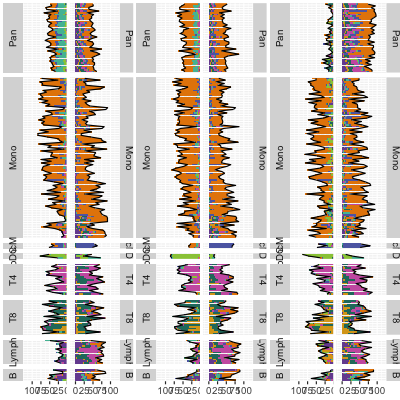

In [48]:
a <- plot_bar_chart(output_prop_noint, output_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
b <- plot_bar_chart(output_sle_prop_noint, output_sle_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
c <- plot_bar_chart(output_sle_asian_prop_noint, output_sle_asian_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(c, file=paste(fig_dir,"/sle_asian_partitioned.png",sep=""),width=3)
d <- plot_bar_chart(output_sle_white_prop_noint, output_sle_white_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(d, file=paste(fig_dir,"/sle_white_partitioned.png",sep=""),width=3);
e <- plot_bar_chart(output_ucsf_healthy_prop_noint, output_ucsf_healthy_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
f <- plot_bar_chart(output_broad_healthy_prop_noint, output_broad_healthy_expr_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(f, file=paste(fig_dir,"/broad_white_partitioned.png",sep=""),width=3);

options(repr.plot.width = 5, repr.plot.height = 5)
grid.arrange(c,d,f, ncol=3)

## Plot stacked barcharts normalized to total PBMC count

Warning message:
“Removed 1 rows containing missing values (geom_bar).”Saving 3 x 7 in image
Saving 3 x 7 in image
Warning message:
“Removed 1 rows containing missing values (geom_bar).”Saving 3 x 7 in image


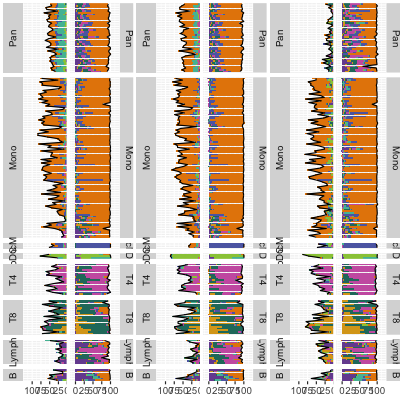

In [49]:
c <- plot_bar_chart(output_sle_asian_prop_noint, output_sle_asian_expr_pbmc_count_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(c, file=paste(fig_dir,"/sle_asian_partitioned_pbmc_counts.png",sep=""),width=3)
d <- plot_bar_chart(output_sle_white_prop_noint, output_sle_white_expr_pbmc_count_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(d, file=paste(fig_dir,"/sle_white_partitioned_pbmc_counts.png",sep=""),width=3);
f <- plot_bar_chart(output_broad_healthy_prop_noint, output_broad_healthy_expr_pbmc_count_noint, pheatmap_pbmc_counts_out, cuttree_out)
ggsave(f, file=paste(fig_dir,"/broad_white_partitioned_pbmc_counts.png",sep=""),width=3);

options(repr.plot.width = 5, repr.plot.height = 5)
grid.arrange(c,d,f, ncol=3)

# Figure 2E: Examples

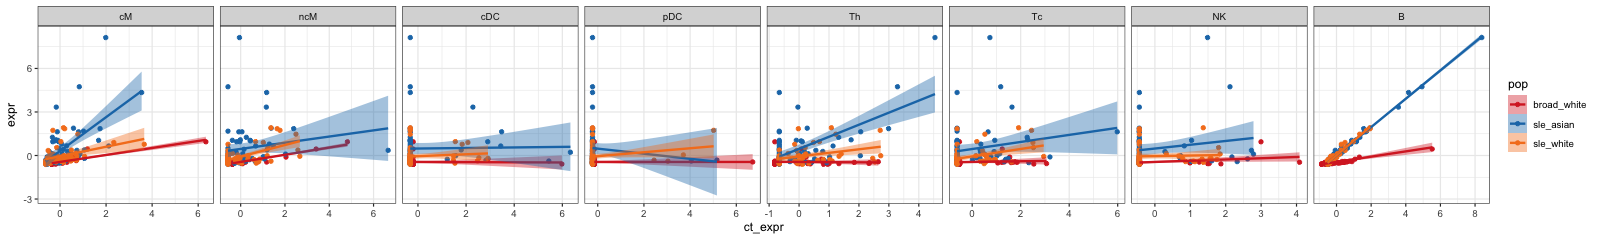

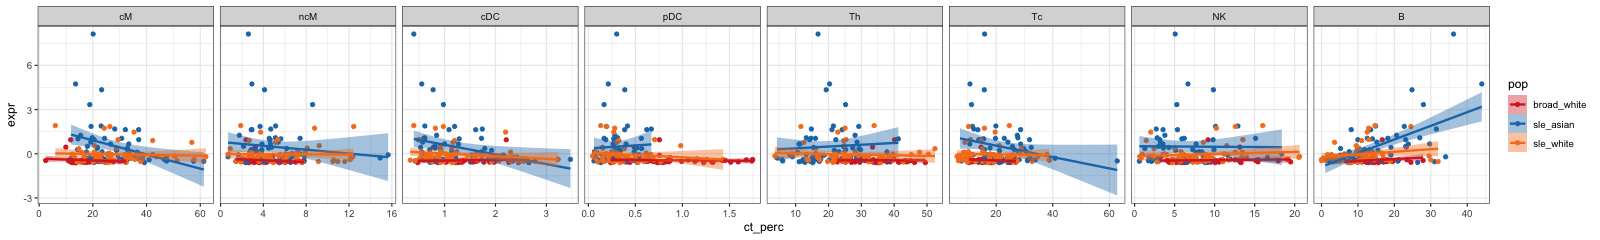

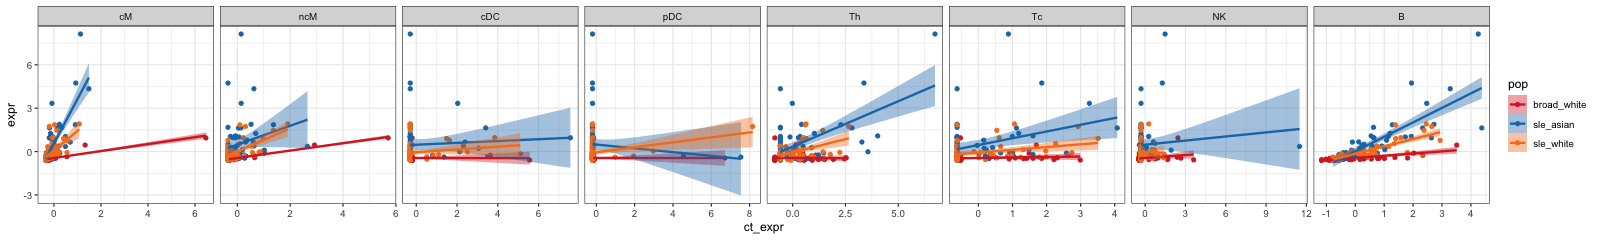

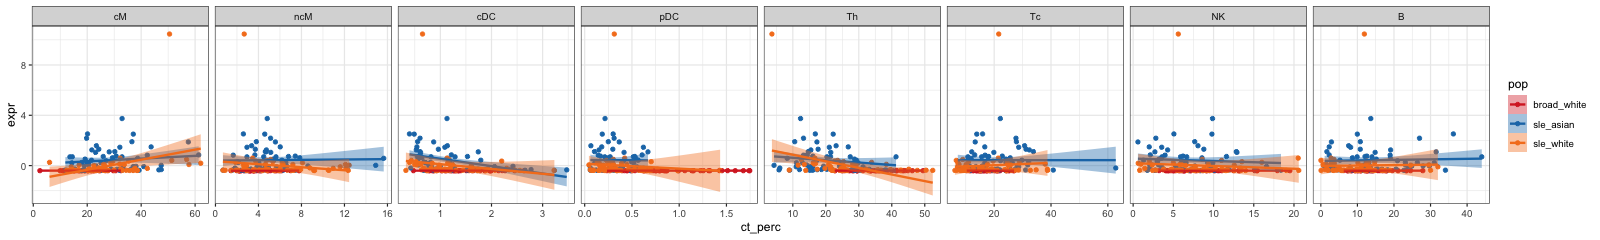

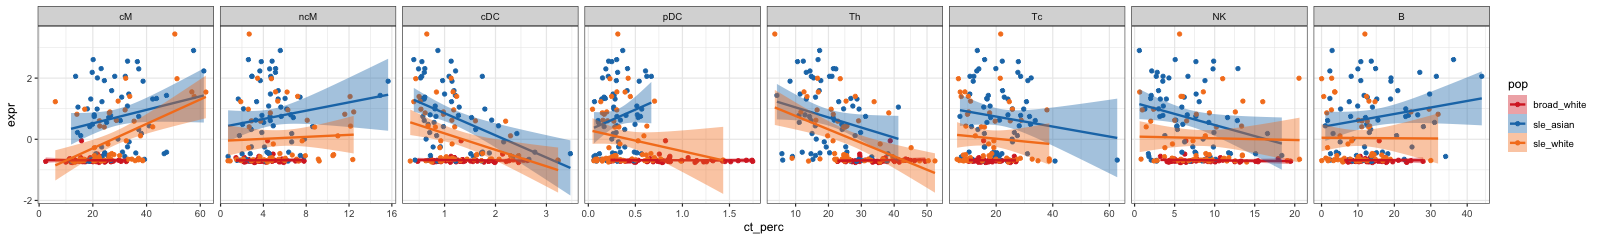

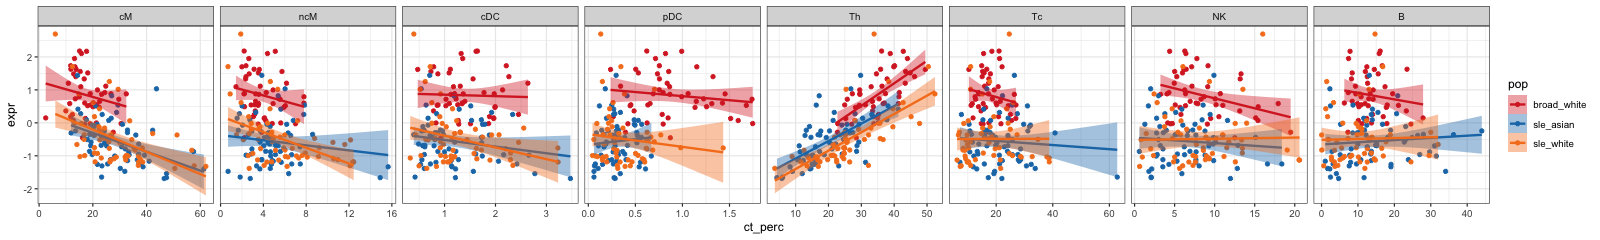

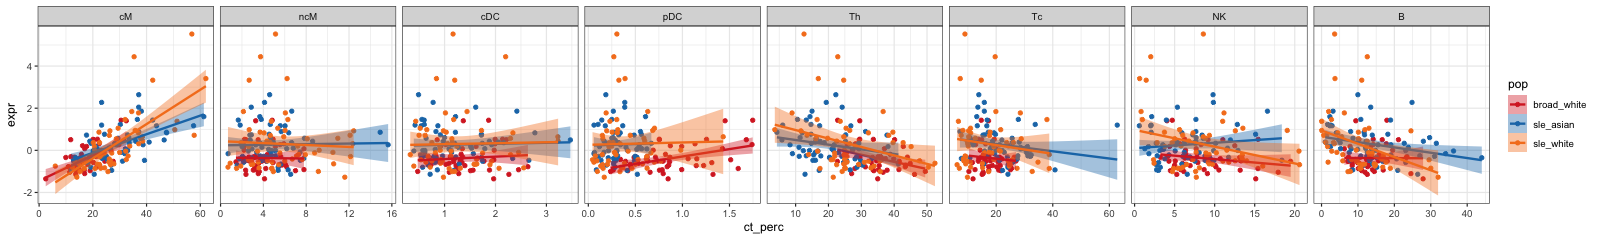

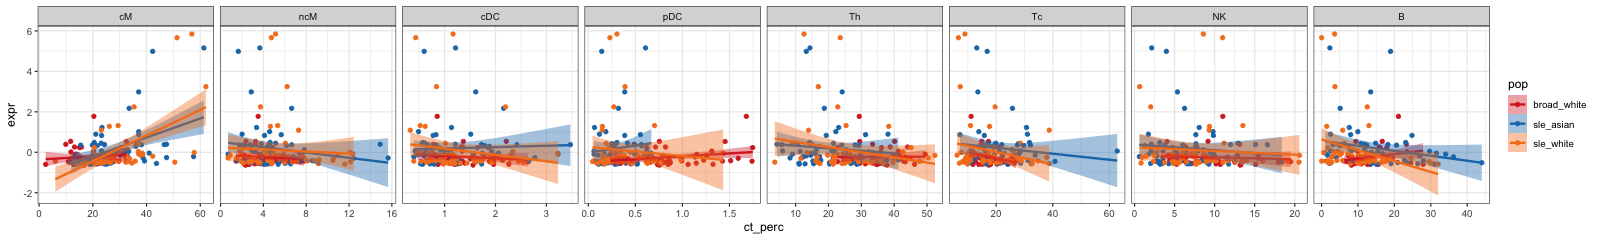

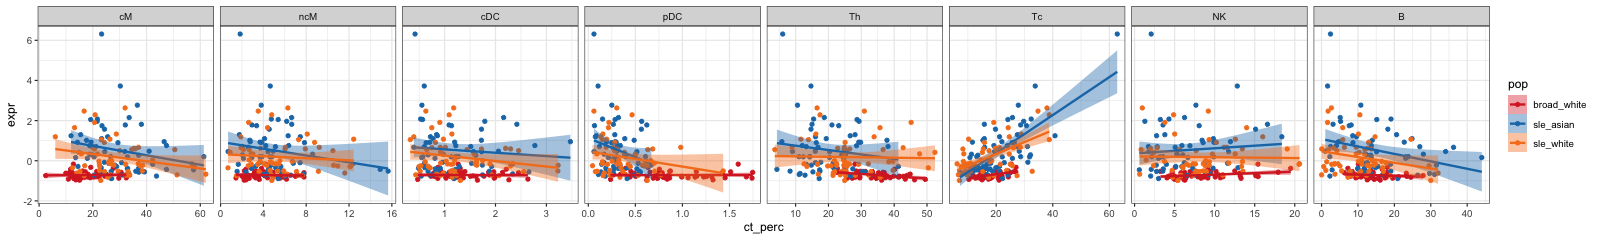

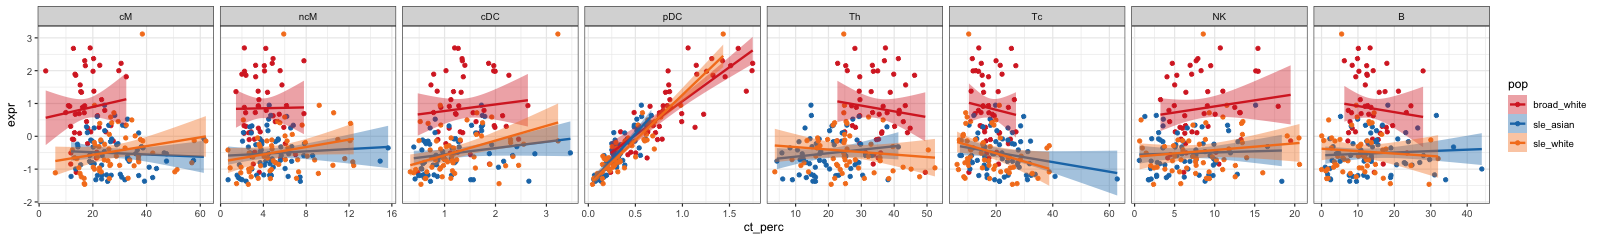

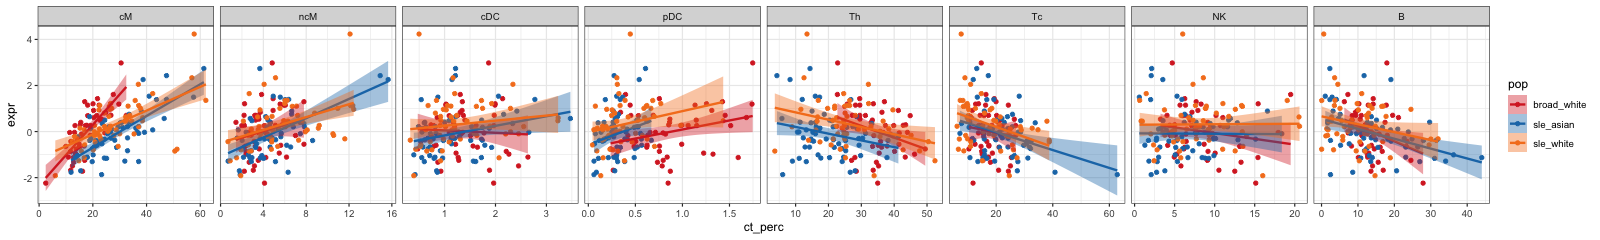

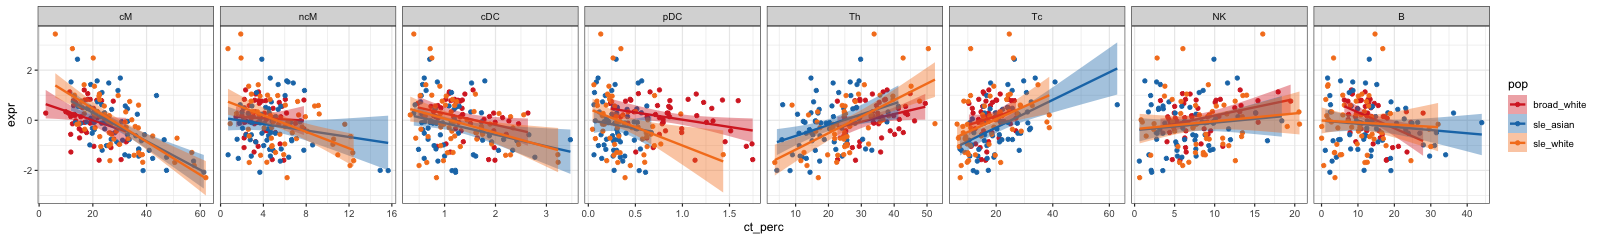

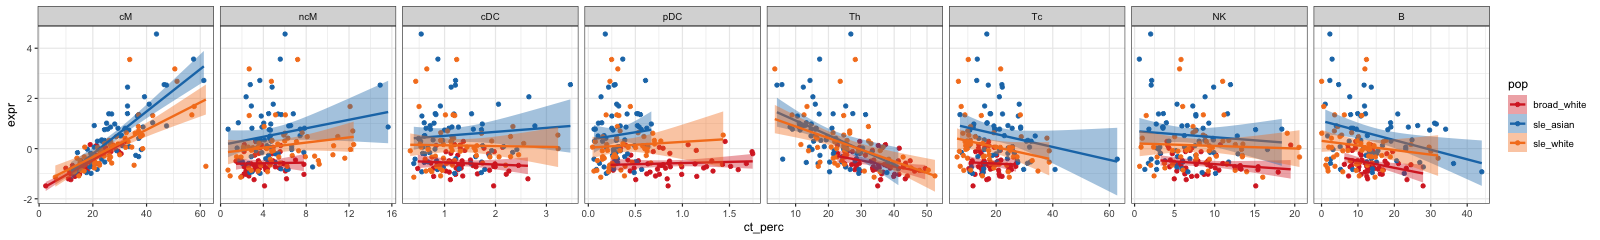

In [50]:
options(repr.plot.width = 20, repr.plot.height = 3)
props_all = rbind(data.frame(props_broad_healthy,pop="broad_white"),
                  data.frame(props[samples_asian,],pop="sle_asian"),
                  data.frame(props[samples_white,],pop="sle_white"))

exprs_all_pbmc_counts = list(exprs_broad_healthy_std_pbmc_counts, exprs_pbmc_counts_std[,samples_asian,], exprs_pbmc_counts_std[,samples_white,])
exprs_all_ct_counts = list(exprs_broad_healthy_std_ct_counts, exprs_ct_counts_std[,samples_asian,], exprs_ct_counts_std[,samples_white,])

expr_all = pbmc_expr_std[,c(broad_healthy_indices, samples_asian, samples_white)]

il6 <- plot_single_gene_expr(expr_all, exprs_all_pbmc_counts, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file=paste(fig_dir,"/IL6_all.png",sep=""),width=11, height=1.75)

il6 <- plot_single_gene_prop(expr_all, props_all, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file=paste(fig_dir,"/IL6_prop.png",sep=""),width=11, height=1.75)

il6 <- plot_single_gene_expr(expr_all, exprs_all_ct_counts, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file=paste(fig_dir,"/IL6_expr.png",sep=""),width=11, height=1.75)

## ifi27 asian vs cau differences
ifi27 <- plot_single_gene_prop(expr_all, props_all, grep("^IFI27$",expr_gene_names)[1])
ggsave(ifi27, file=paste(fig_dir,"/IFI27.png",sep=""),width=11, height=2)
ifi44l <- plot_single_gene_prop(expr_all, props_all, grep("^IFI44L$",expr_gene_names)[1])
ggsave(ifi44l, file=paste(fig_dir,"/IFI44L.png",sep=""),width=11, height=2)
ccr7 <- plot_single_gene_prop(expr_all, props_all, grep("^CCR7$",expr_gene_names)[1])
ggsave(ccr7, file=paste(fig_dir,"/CCR7.png",sep=""),width=11, height=2)
nlrp3 <- plot_single_gene_prop(expr_all, props_all, grep("^NLRP3$",expr_gene_names)[1])
ggsave(nlrp3, file=paste(fig_dir,"/NLRP3.png",sep=""), width=11, height=2)
thbs1 <- plot_single_gene_prop(expr_all, props_all, grep("^THBS1$",expr_gene_names)[1])
ggsave(thbs1, file=paste(fig_dir,"/THBS1.png",sep=""), width=11, height=2)
ifng <- plot_single_gene_prop(expr_all, props_all, grep("^IFNG$",expr_gene_names)[1])
ggsave(ifng, file=paste(fig_dir,"/IFNG.png",sep=""),width=11, height=2)
lilra4 <- plot_single_gene_prop(expr_all, props_all, grep("^LILRA4$",expr_gene_names)[1])
ggsave(lilra4, file=paste(fig_dir,"/LILRA4.png",sep=""),width=11, height=2)
cd4 <- plot_single_gene_prop(expr_all, props_all, grep("^CD4$",expr_gene_names)[1])
ggsave(cd4, file=paste(fig_dir,"/CD4.png",sep=""),width=11, height=2)
lck <- plot_single_gene_prop(expr_all, props_all, grep("^LCK$",expr_gene_names)[1])
ggsave(lck, file=paste(fig_dir,"/LCK.png",sep=""),width=11, height=2)
cd14 <- plot_single_gene_prop(expr_all, props_all, grep("^CD14$",expr_gene_names)[1])
ggsave(cd14, file=paste(fig_dir,"/CD14.png",sep=""),width=11, height=2)


In [51]:
rbind(data.frame(t(output_sle_prop_noint["C1QA",]),type="sle prop"),
data.frame(t(output_broad_healthy_prop_noint["C1QA",]),type="broad healthy prop"),
data.frame(t(output_sle_expr_noint["C1QA",]), type="sle expr"),
data.frame(t(output_broad_healthy_expr_noint["C1QA",]), type="broad healthy expr"))

cM         Th          B           NK          ncM      Tc        cDC      
1 10.7941783 4.814577294 -0.10120779 -0.09684908 14.54008 2.7120688 2.5094032
2  0.3038314 0.005503381  3.76889137 -0.65166185 41.70779 0.2625503 0.4297955
3  0.5980041 0.029111860  0.05085541  0.01098569 62.83572 0.2381089 0.2494593
4  0.6683193 0.051819758  0.06638155 -0.16718060 49.08876 0.2528284 1.0030746
  pDC          total.r2 adj.r2   total.prop_expr.r2 adj.prop_expr.r2
1  0.708384370 35.88064 31.17463 99.88469           92.53677        
2  2.586712088 48.41341 37.55307 99.74103           78.63387        
3 -0.008200509 64.00405 61.36214 99.88469           92.53677        
4  0.363613460 51.32762 41.08080 99.74103           78.63387        
  type              
1 sle prop          
2 broad healthy prop
3 sle expr          
4 broad healthy expr

In [52]:
rbind(data.frame(t(output_sle_prop_noint["IL6",]),type="sle prop"),
data.frame(t(output_broad_healthy_prop_noint["IL6",]),type="broad healthy prop"),
data.frame(t(output_sle_expr_noint["IL6",]), type="sle expr"),
data.frame(t(output_broad_healthy_expr_noint["IL6",]), type="broad healthy expr"))

cM         Th          B        NK          ncM        Tc        cDC        
1 -1.7725154 -0.36083607 27.72155 -0.15610189  0.8801311 0.1792116  4.95360450
2  0.2032602  0.08076279  4.98402  0.33483302  2.0371288 0.5198866  1.18440915
3  4.3365449  1.00365600 61.59494  0.09281226  0.9797731 0.3299376  0.07671415
4 55.9266895  0.13595668 21.83973  0.63816478 10.9475759 0.1018344 -0.04407943
  pDC         total.r2  adj.r2    total.prop_expr.r2 adj.prop_expr.r2
1 -0.13438832 31.310651 26.269231 99.73965           92.38109        
2  0.20405752  9.548359 -9.494092 99.12003           77.88214        
3  0.01461776 68.428999 66.111861 99.73965           92.38109        
4  0.02579527 89.571670 87.376232 99.12003           77.88214        
  type              
1 sle prop          
2 broad healthy prop
3 sle expr          
4 broad healthy expr

In [53]:
rbind(data.frame(t(output_sle_prop_noint["IFNG",]),type="sle prop"),
data.frame(t(output_broad_healthy_prop_noint["IFNG",]),type="broad healthy prop"),
data.frame(t(output_sle_expr_noint["IFNG",]), type="sle expr"),
data.frame(t(output_broad_healthy_expr_noint["IFNG",]), type="broad healthy expr"))

cM        Th        B         NK          ncM        Tc       cDC        
1 0.3346103 0.5069577 2.1923766  0.02547212  0.3128723 44.23305  0.33817852
2 0.3056822 7.1142666 1.7022194 13.35384073 -0.4499023 23.01875 -0.03590943
3 0.6937139 2.6815980 0.1810468  6.94947228  0.1687267 34.64761  0.17834025
4 0.8877861 6.8041700 0.4501193  6.08476266 -0.0644286 31.97565  0.24089490
  pDC          total.r2 adj.r2   total.prop_expr.r2 adj.prop_expr.r2
1  0.445852273 48.38937 44.60143 93.89484           86.10731        
2 -0.051268126 44.95768 33.36983 91.50088           68.65897        
3  0.004968464 45.50547 41.50588 93.89484           86.10731        
4  0.164251788 46.54320 35.28914 91.50088           68.65897        
  type              
1 sle prop          
2 broad healthy prop
3 sle expr          
4 broad healthy expr

In [54]:
rbind(data.frame(t(output_sle_prop_noint["CCR7",]),type="sle prop"),
data.frame(t(output_broad_healthy_prop_noint["CCR7",]),type="broad healthy prop"),
data.frame(t(output_sle_expr_noint["CCR7",]), type="sle expr"),
data.frame(t(output_broad_healthy_expr_noint["CCR7",]), type="broad healthy expr"))

cM         Th       B          NK         ncM        Tc         cDC       
1 -1.7116336 44.11817  0.8658302 -0.1564719 3.28058807 -0.4490734 4.97371830
2 -3.1918478 51.16154 -1.5651821  7.0767565 5.82678750 -1.3829452 0.17038656
3  0.6068583 24.68255  2.9529342  0.2794079 0.20220047 18.2816135 0.18270764
4  0.8884761 27.60303  3.4639054  0.3840859 0.05914507  9.7542022 0.03924793
  pDC         total.r2 adj.r2   total.prop_expr.r2 adj.prop_expr.r2
1 -0.16699761 50.75413 47.13976 97.9735            90.48532        
2 -0.86788662 57.22760 48.22289 99.5305            78.37902        
3  0.03110055 47.21937 43.34556 97.9735            90.48532        
4  0.11079536 42.30289 30.15613 99.5305            78.37902        
  type              
1 sle prop          
2 broad healthy prop
3 sle expr          
4 broad healthy expr

In [55]:
rbind(data.frame(t(output_sle_prop_noint["CD8B",]),type="sle prop"),
data.frame(t(output_broad_healthy_prop_noint["CD8B",]),type="broad healthy prop"),
data.frame(t(output_sle_expr_noint["CD8B",]), type="sle expr"),
data.frame(t(output_broad_healthy_expr_noint["CD8B",]), type="broad healthy expr"))

cM         Th         B          NK         ncM        Tc       cDC        
1 -2.5352346 -0.3753131 -0.9777059  0.2640592  0.4988152 59.13243  0.43380794
2 -0.3209750  3.6573240  0.4729911 -0.1494455 11.3222920 37.81229  1.51075507
3  0.1660800  5.4804086  0.2787154  0.2015110  0.1343748 30.93950 -0.01430558
4 -0.2806818 11.4579410  0.2716294  0.9517615  0.1282209 30.46232  0.33363761
  pDC         total.r2 adj.r2   total.prop_expr.r2 adj.prop_expr.r2
1 2.569213089 59.01007 56.00164 96.24481           88.62975        
2 0.658271026 54.96350 45.48213 98.29430           76.88257        
3 0.048458700 37.23474 32.62812 96.24481           88.62975        
4 0.005966873 43.33080 31.40044 98.29430           76.88257        
  type              
1 sle prop          
2 broad healthy prop
3 sle expr          
4 broad healthy expr

In [56]:
rbind(data.frame(t(output_sle_prop_noint["CD3E",]),type="sle prop"),
data.frame(t(output_broad_healthy_prop_noint["CD3E",]),type="broad healthy prop"),
data.frame(t(output_sle_expr_noint["CD3E",]), type="sle expr"),
data.frame(t(output_broad_healthy_expr_noint["CD3E",]), type="broad healthy expr"))

cM         Th        B          NK        ncM         Tc        cDC      
1 -2.4846982 37.075171 -2.2751854 -1.536685 -0.35894515 50.379502 1.5348462
2 -4.3519581 25.391979  9.0343854  5.497294  0.06134909 14.884688 4.4777427
3  0.1765387  6.349761  0.2896517  1.550946  0.06177488  6.519969 0.1222849
4  2.9215048 19.517767  2.9352825  2.358465  1.09028498  9.228853 0.5881381
  pDC         total.r2 adj.r2   total.prop_expr.r2 adj.prop_expr.r2
1  1.15808802 83.49209 82.28050 98.55154           91.10578        
2  4.98496185 59.98044 51.55527 99.04748           77.79432        
3 -0.01147755 15.05945  8.82528 98.55154           91.10578        
4  0.42674504 39.06704 26.23905 99.04748           77.79432        
  type              
1 sle prop          
2 broad healthy prop
3 sle expr          
4 broad healthy expr

# Figure 2F: Disease prediction

In [57]:
ifn_genes_use=intersect(ifn_crow[['V1']] , expr_gene_names)
print(length(ifn_genes_use))

[1] 30


In [58]:
comp_indices <- c(60,63,64,65,66,67,68,69,70,71); 

sledai=cbind(ct_annotation_one, joined_pivot[, ..comp_indices])
sledai[['disease']]=1
sledai[['disease']][grep('healthy', sledai[['disease_pop_cov']])]=0

comp = sledai[,c(3:(ncol(sledai)-1))]
comp[is.na(comp)] <- 0;

comp_lineage = data.frame(lymph=comp$B+comp$NK+comp$ProlifT+comp$Tc+comp$Th, mye=comp$cM+comp$ncM+comp$pDC+comp$cDC)
rownames(comp_lineage) <- rownames(comp);

In [59]:
pbmc_var_genes <- rownames(pbmc_expr_std)[order(apply(pbmc_expr, 1, function(x) {var(x)}),decreasing=T)[1:500]]
cm_var_genes <- rownames(cm_expr_ct_counts_std)[order(apply(cm_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
ncm_var_genes <- rownames(ncm_expr_ct_counts_std)[order(apply(ncm_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
th_var_genes <- rownames(th_expr_ct_counts_std)[order(apply(th_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
tc_var_genes <- rownames(tc_expr_ct_counts_std)[order(apply(tc_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
nk_var_genes <- rownames(nk_expr_ct_counts_std)[order(apply(nk_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
cdc_var_genes <- rownames(cdc_expr_ct_counts_std)[order(apply(cdc_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
b_var_genes <- rownames(b_expr_ct_counts_std)[order(apply(b_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]
pdc_var_genes <- rownames(pdc_expr_ct_counts_std)[order(apply(pdc_expr_ct_counts, 1, function(x) {var(x)}),decreasing=T)[1:500]]

In [60]:
cm_pbmc_count_var_genes <- rownames(cm_expr_pbmc_counts_std)[order(apply(cm_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
ncm_pbmc_count_var_genes <- rownames(ncm_expr_pbmc_counts_std)[order(apply(ncm_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
th_pbmc_count_var_genes <- rownames(th_expr_pbmc_counts_std)[order(apply(th_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
tc_pbmc_count_var_genes <- rownames(tc_expr_pbmc_counts_std)[order(apply(tc_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
nk_pbmc_count_var_genes <- rownames(nk_expr_pbmc_counts_std)[order(apply(nk_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
cdc_pbmc_count_var_genes <- rownames(cdc_expr_pbmc_counts_std)[order(apply(cdc_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
b_pbmc_count_var_genes <- rownames(b_expr_pbmc_counts_std)[order(apply(b_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]
pdc_pbmc_count_var_genes <- rownames(pdc_expr_pbmc_counts_std)[order(apply(pdc_expr_pbmc_counts, 1, var),decreasing=T)[1:1000]]

In [61]:
#prediction with all cts
print(dim(all_expr_pbmc_counts_std_sig))
print(head(ct_annotation))


all_expr_cts_ifn_pbmc_counts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      ncm=ncm_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      pdc=pdc_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                        cdc=cdc_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      th=th_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      tc=tc_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                       nk=nk_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),],
                      b=b_expr_pbmc_counts_std[match(ifn_genes_use,expr_gene_names),]
                      )



all_expr_cts_pbmc_counts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      ncm=ncm_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      cdc=cdc_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      pdc=pdc_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      th=th_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      tc=tc_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                       nk=nk_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      b=b_expr_pbmc_counts_std[match(deseq_sig_genes,expr_gene_names),]
                      )


all_expr_cts_var_pbmc_counts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_pbmc_counts_std[match(cm_pbmc_count_var_genes,expr_gene_names),],
                      ncm=ncm_expr_pbmc_counts_std[match(ncm_pbmc_count_var_genes,expr_gene_names),],
                      cdc=cdc_expr_pbmc_counts_std[match(cdc_pbmc_count_var_genes,expr_gene_names),],
                      pdc=pdc_expr_pbmc_counts_std[match(pdc_pbmc_count_var_genes,expr_gene_names),],
                      th=th_expr_pbmc_counts_std[match(th_pbmc_count_var_genes,expr_gene_names),],
                      tc=tc_expr_pbmc_counts_std[match(tc_pbmc_count_var_genes,expr_gene_names),],
                       nk=nk_expr_pbmc_counts_std[match(nk_pbmc_count_var_genes,expr_gene_names),],
                      b=b_expr_pbmc_counts_std[match(b_pbmc_count_var_genes,expr_gene_names),]
                      )


all_expr_cts_ifn <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      ncm=ncm_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      pdc=pdc_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                        cdc=cdc_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      th=th_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      tc=tc_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                       nk=nk_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),],
                      b=b_expr_ct_counts_std[match(ifn_genes_use,expr_gene_names),]
                      )



all_expr_cts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      ncm=ncm_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      cdc=cdc_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      pdc=pdc_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      th=th_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      tc=tc_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                       nk=nk_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),],
                      b=b_expr_ct_counts_std[match(deseq_sig_genes,expr_gene_names),]
                      )


all_expr_cts_var <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],
                      cm=cm_expr_ct_counts_std[match(cm_var_genes,expr_gene_names),],
                      ncm=ncm_expr_ct_counts_std[match(ncm_var_genes,expr_gene_names),],
                      cdc=cdc_expr_ct_counts_std[match(cdc_var_genes,expr_gene_names),],
                      pdc=pdc_expr_ct_counts_std[match(pdc_var_genes,expr_gene_names),],
                      th=th_expr_ct_counts_std[match(th_var_genes,expr_gene_names),],
                      tc=tc_expr_ct_counts_std[match(tc_var_genes,expr_gene_names),],
                      nk=nk_expr_ct_counts_std[match(nk_var_genes,expr_gene_names),],
                      b=b_expr_ct_counts_std[match(b_var_genes,expr_gene_names),]
                      )

##add the CT comp to CT expr
all_includect_comp_expr=rbind(all_expr_cts, t(comp))
all_includect_comp_expr_ifn=rbind(all_expr_cts_ifn, t(comp))
all_includect_comp_expr_var=rbind(t(apply(t(comp),1,function(x){(x-mean(x))/sd(x)})), all_expr_cts_var)


[1]  198 1683
                         type disease_pop_cov sledaiscore
pbmc.1019_lupus7.13      PBMC        sleWHITE           0
pbmc.903648200_lupus7.13 PBMC        sleWHITE           2
pbmc.1127_lupus7.19      PBMC        sleWHITE           0
pbmc.IGTB195_lupus7.19   PBMC    healthyWHITE           0
pbmc.IGTB498_lupus7.19   PBMC    healthyWHITE           0
pbmc.IGTB1650_immvar8.31 PBMC    healthyWHITE           0


## Predicting cases and controls together

In [62]:
disease_performance <- qualitative_prediction(trait="disease_cov", method="glmnet")
t(disease_performance)

[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.762768031189084 0.930961663417804 0.944282001299545
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.973944119558155 0.976405610977334

In [63]:
disease_svm_performance <- qualitative_prediction(trait="disease_cov", method="svmLinear")
t(disease_svm_performance)

[,1]              [,2]             [,3]              [,4]  
type        comp_lineage      comp             PBMC IFN          CT VAR
performance 0.765204678362573 0.92953216374269 0.935964912280702 1     
            [,5]       
type        CT VAR COMP
performance 1

## Predicting cases only outcomes

In [64]:
disease_indices <- which(joined_pivot$disease_cov == "sle");

sledaiscore_performance <- quantitative_prediction(trait="sledaiscore", indices=disease_indices, method="glmnet")
t(sledaiscore_performance)
sledaiscore_svm_performance <- quantitative_prediction(trait="sledaiscore", indices=disease_indices, method="svmLinear")
t(sledaiscore_svm_performance)

[,1]              [,2]             [,3]             
type        comp_lineage      comp             PBMC IFN         
performance 0.144780992529381 0.16340920035465 0.210888054250155
            [,4]              [,5]            
type        CT VAR            CT VAR COMP     
performance 0.243673997423616 0.22083088267557

[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.139075860256185 0.163042678380542 0.208058896309363
            [,4]              [,5]           
type        CT VAR            CT VAR COMP    
performance 0.135177531185586 0.2404314436489

In [65]:
pbmc_indices <- which(joined_pivot$pbmc > 0);

joined_pivot$mono_rat <- joined_pivot$AbsMono/(joined_pivot$AbsMono+joined_pivot$AbsLympho);
mono_rat_performance <- quantitative_prediction(trait="mono_rat", indices=intersect(disease_indices,pbmc_indices),method="glmnet")
t(mono_rat_performance)
mono_rat_svm_performance <- quantitative_prediction(trait="mono_rat", indices=intersect(disease_indices,pbmc_indices),method="svmLinear")
t(mono_rat_svm_performance)

[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.693797272229788 0.666206747848425 0.444920766712696
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.150232720606291 0.499979504438998

[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.649031758630631 0.686852463169426 0.407221574006043
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.297848627561114 0.317342952872296

In [66]:
kidney_performance <- qualitative_prediction(trait="kidney", indices=disease_indices, method='glmnet')
t(kidney_performance)
kidney_svm_performance <- qualitative_prediction(trait="kidney", indices=disease_indices, method='svmLinear')
t(kidney_svm_performance)

[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.509382284382284 0.454020979020979 0.438312613312613
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.618919968919969 0.602900802900803

[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.475874125874126 0.523543123543124 0.467016317016317
            [,4]              [,5]            
type        CT VAR            CT VAR COMP     
performance 0.591375291375291 0.63513986013986

In [67]:
sledaiantidsdna_performance <- qualitative_prediction(trait="sledaiantidsdna", indices=disease_indices, method='glmnet')
t(sledaiantidsdna_performance)
sledaiantidsdna_svm_performance <- qualitative_prediction(trait="sledaiantidsdna", indices=disease_indices, method='svmLinear')
t(sledaiantidsdna_svm_performance)


[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.584848484848485 0.617087542087542 0.636195286195286
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.606818181818182 0.592255892255892

[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.584848484848485 0.629545454545455 0.599242424242424
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.534090909090909 0.543333333333333

In [68]:
sledailowcomp_performance <- qualitative_prediction(trait="sledailowcomp", indices=disease_indices, method='glmnet')
t(sledailowcomp_performance)
sledailowcomp_svm_performance <- qualitative_prediction(trait="sledailowcomp", indices=disease_indices, method='svmLinear')
t(sledailowcomp_svm_performance)


[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.720745920745921 0.696069671069671 0.703587153587154
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.689160839160839 0.694768194768195

[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.720745920745921 0.739102564102564 0.688053613053613
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.609440559440559 0.668181818181818

In [69]:
sledairash_performance <- qualitative_prediction(trait="sledairash", indices=disease_indices, method='glmnet')
t(sledairash_performance)
sledairash_svm_performance <- qualitative_prediction(trait="sledairash", indices=disease_indices, method='svmLinear')
t(sledairash_svm_performance)

Warning message:
“from glmnet Fortran code (error code -87); Convergence for 87th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”

[,1]              [,2]              [,3]             
type        comp_lineage      comp              PBMC IFN         
performance 0.873484848484849 0.865675990675991 0.812645687645688
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.873963998963999 0.879377104377104

[,1]              [,2]            [,3]             
type        comp_lineage      comp            PBMC IFN         
performance 0.874009324009324 0.8745337995338 0.841083916083916
            [,4]              [,5]             
type        CT VAR            CT VAR COMP      
performance 0.882983682983683 0.873892773892774

## Summarize and plot

In [70]:
df <- rbind(data.frame(disease_performance, trait="disease_status"),
                 data.frame(sledaiscore_performance, trait="sledai_cases"),
                 data.frame(mono_rat_performance, trait="mono_rat"),
                 data.frame(sledailowcomp_performance, trait="sledailowcomp"),
                data.frame(sledaiantidsdna_performance, trait="sledaiantidsdna"),
                data.frame(sledairash_performance, trait="sledairash"),
                data.frame(kidney_performance, trait="kidney"))

df_svm <- rbind(data.frame(disease_svm_performance, trait="disease_status"),
                 data.frame(sledaiscore_svm_performance, trait="sledai_cases"),
                 data.frame(mono_rat_svm_performance, trait="mono_rat"),
                 data.frame(sledailowcomp_svm_performance, trait="sledailowcomp"),
                data.frame(sledaiantidsdna_svm_performance, trait="sledaiantidsdna"),
                data.frame(sledairash_svm_performance, trait="sledairash"),
                data.frame(kidney_svm_performance, trait="kidney"))


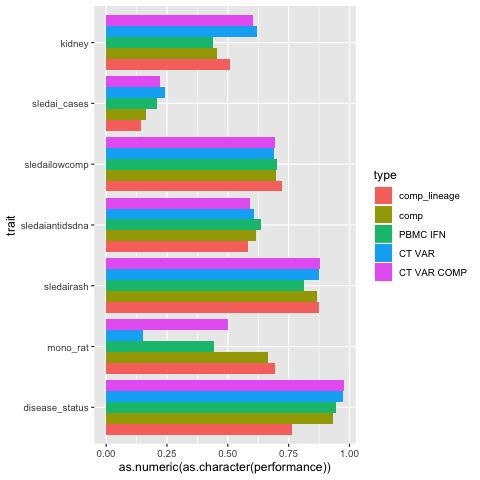

In [71]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res=80)

df$performance <- as.numeric(as.character(df$performance));
df$type <- factor(df$type, levels=c("comp_lineage","comp", "PBMC IFN", "CT VAR", "CT VAR COMP"))
df$trait <- factor(df$trait, levels=c("disease_status","mono_rat", "sledairash", "sledaiantidsdna", "sledailowcomp", "sledai_cases", "kidney"))

ggplot(aes(x=trait, y=as.numeric(as.character(performance)), fill=type),data=df)+geom_bar(stat="identity",position=position_dodge())+coord_flip()
ggsave(paste(fig_dir,"/performance_glmnet.png",sep=""),height=6,width=6)